In [1]:
# BATCH:256
# batch_size:256
# data_path:"/data2"
# decay:0.7834769413661389
# EPOCH:20
# hard_reset:true
# IMAGE_SIZE:32
# learning_rate:0.007176761798504128
# pre_spike_weight:5.165214142219577
# rate_coding:true
# TIME_STEP:9
# time_step:9
# v_decay:0.7834769413661389
# v_reset:0
# v_threshold:1
# which_data:"CIFAR10"


# BATCH:256
# batch_size:256
# data_path:"/data2"
# decay:0.38993471232202725
# EPOCH:20
# hard_reset:true
# IMAGE_SIZE:28
# learning_rate:0.06285718352377828
# pre_spike_weight:6.21970124592063
# rate_coding:true
# TIME_STEP:16
# time_step:16
# v_decay:0.38993471232202725
# v_reset:0
# v_threshold:1
# which_data:"MNIST"

# BATCH:64
# batch_size:64
# data_path:"/data2"
# decay:0.9266077968579136
# EPOCH:20
# hard_reset:true
# IMAGE_SIZE:28
# learning_rate:0.07732456724854177
# pre_spike_weight:1.5377416716615555
# rate_coding:true
# TIME_STEP:7
# time_step:7
# v_decay:0.9266077968579136
# v_reset:0
# v_threshold:1
# which_data:"FASHION_MNIST"

In [2]:
# Copyright (c) 2024 Byeonghyeon Kim 
# github site: https://github.com/bhkim003/ByeonghyeonKim
# email: bhkim003@snu.ac.kr
 
# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in
# the Software without restriction, including without limitation the rights to
# use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
# the Software, and to permit persons to whom the Software is furnished to do so,
# subject to the following conditions:
 
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
 
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
# FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
# COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
# IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.


In [3]:
import sys
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt


from snntorch import spikegen

 
import wandb

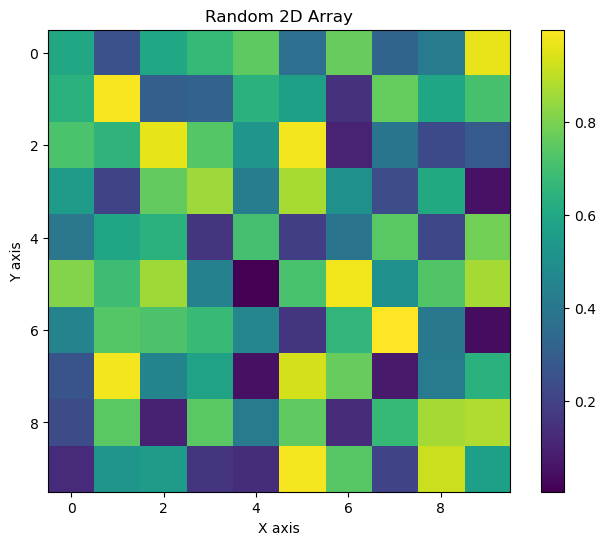

In [4]:
# my module import
from modules import *

In [5]:
    
class RESERVOIR(nn.Module):
    def __init__ (self, TIME_STEP=8, in_spike_size=28, in_channel=1, receptive_size=3, v_init=0, v_decay=0.6, v_threshold=1, v_reset=0, hard_reset=True, pre_spike_weight=1,
                  FC_RESERVOIR=False):
        super(RESERVOIR, self).__init__()
        self.TIME_STEP = TIME_STEP
        self.in_spike_size = in_spike_size
        self.in_channel = in_channel
        self.receptive_size = receptive_size #3
        self.v_init = v_init
        self.v_decay = v_decay
        self.v_threshold = v_threshold
        self.v_reset = v_reset
        self.hard_reset = hard_reset
        self.pre_spike_weight = pre_spike_weight
        self.FC_RESERVOIR = FC_RESERVOIR

        self.out_channel = 1

        # 파라미터 
        if self.FC_RESERVOIR == True:
            self.reservoir = nn.Linear(in_features=self.in_channel*self.in_spike_size*self.in_spike_size, out_features=self.in_channel*self.in_spike_size*self.in_spike_size, bias=True)
        else:
            self.reservoir = nn.Conv2d(in_channels=self.in_channel, out_channels=self.in_channel, 
                                            kernel_size=self.receptive_size, 
                                            stride=1, padding=1, groups=self.in_channel)

        # kaiming 초기화
        nn.init.kaiming_normal_(self.reservoir.weight, mode='fan_out', nonlinearity='relu')
        nn.init.constant_(self.reservoir.bias, 0)

        # membrane potential 초기화
        self.v = torch.full((self.in_channel, self.in_spike_size, self.in_spike_size), fill_value=self.v_init, requires_grad=False)

        
    def forward(self, pre_spike):    
        # pre_spike [TIME_STEP, batch_size, in_channel, in_spike_size, in_spike_size]

        v = torch.full_like(pre_spike[0], fill_value=self.v_init, requires_grad=False)
        post_spike = torch.zeros_like(pre_spike[0], requires_grad=False)
        # v [batch_size, in_channel, in_spike_size, in_spike_size]
        # recurrent [batch_size, in_channel, in_spike_size, in_spike_size]

        # timestep 안 맞으면 종료
        assert pre_spike.size(0) == self.TIME_STEP, f"Time step mismatch: {pre_spike.size(0)} vs {self.TIME_STEP}"

        output = []
        for t in range (self.TIME_STEP):
            # depthwise conv reservoir: pre_spike[t] [batch_size, in_channel, in_spike_size, in_spike_size]
            # fc conv reservoir: pre_spike[t] [batch_size, in_channel*in_spike_size*in_spike_size]
            input_current = self.pre_spike_weight * pre_spike[t]
                
            recurrent_current = self.reservoir(post_spike)
            current = input_current + recurrent_current
            # current [batch_size, in_channel, in_spike_size, in_spike_size] # kernel size 3이니까 사이즈 유지
            
            # decay and itegrate
            v = v*self.v_decay + current

            # post spike
            post_spike = (v >= self.v_threshold).float()

            output.append(post_spike)
            
            #reset
            if self.hard_reset: # hard reset
                v = (1 - post_spike)*v + post_spike*self.v_reset 
            else: # soft reset
                v = v - post_spike*self.v_threshold

        output = torch.stack(output, dim=0)
        return output

In [6]:
class RESERVOIR_NET(nn.Module):
    def __init__(self, TIME_STEP=8, CLASS_NUM=10, in_spike_size=28, in_channel=1, receptive_size=3, v_init=0, v_decay=0.6, v_threshold=1, v_reset=0, hard_reset=True, pre_spike_weight=1,
                 no_reservoir = False, FC_RESERVOIR=False):
        super(RESERVOIR_NET, self).__init__()
        self.TIME_STEP = TIME_STEP
        self.no_reservoir = no_reservoir
        self.FC_RESERVOIR = FC_RESERVOIR

        if self.no_reservoir == False:
            self.reservoir = RESERVOIR(TIME_STEP = self.TIME_STEP, in_spike_size=in_spike_size, in_channel=in_channel, receptive_size=receptive_size, v_init=v_init, v_decay=v_decay, v_threshold=v_threshold, v_reset=v_reset, hard_reset=hard_reset, pre_spike_weight=pre_spike_weight,
                                       FC_RESERVOIR=FC_RESERVOIR)
        
        self.classifier = nn.Linear(in_features=in_channel*in_spike_size*in_spike_size, out_features=CLASS_NUM)

    def forward(self, x):
        assert self.TIME_STEP == x.size(1), f"Time step mismatch: {x.size(1)} vs {self.TIME_STEP}"

        # x size [batch_size, TIME_STEP, in_channel, in_spike_size, in_spike_size]
        x = x.permute(1,0,2,3,4)
        # x size [TIME_STEP, batch_size, in_channel, in_spike_size, in_spike_size]

        if (self.FC_RESERVOIR == True):
            x = x.reshape(x.size(0), x.size(1), -1)

        if self.no_reservoir == False:
            with torch.no_grad():
                x = self.reservoir(x) # reservoir weight는 학습 안함

        T, B, *spatial_dims = x.shape

        x = x.reshape(T * B, -1) # time,batch 축은 합쳐서 FC에 삽입

        x = self.classifier(x)

        x = x.view(T , B, -1).contiguous() 
        
        x = x.mean(dim=0)
        return x

In [7]:
def data_loader(which_data, data_path, rate_coding, BATCH, IMAGE_SIZE, TIME, dvs_duration, dvs_clipping):
    if which_data == 'MNIST':
        if rate_coding :
            transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0,), (1,))])
        else : 
            transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,),(0.5))])

        trainset = torchvision.datasets.MNIST(root=data_path,
                                            train=True,
                                            download=True,
                                            transform=transform)


        testset = torchvision.datasets.MNIST(root=data_path,
                                            train=False,
                                            download=True,
                                            transform=transform)

        train_loader = DataLoader(trainset,
                                batch_size =BATCH,
                                shuffle = True,
                                num_workers =2)
        test_loader = DataLoader(testset,
                                batch_size =BATCH,
                                shuffle = False,
                                num_workers =2)
        synapse_conv_in_channels = 1
        CLASS_NUM = 10


    

    elif (which_data == 'CIFAR10'):

        if rate_coding :
            # transform_train = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            #                                     transforms.RandomHorizontalFlip(),
            #                                     transforms.ToTensor()])

            # transform_test = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            #                                     transforms.ToTensor()])
            
            transform_train = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                                transforms.RandomHorizontalFlip(),
                                                transforms.ToTensor()])
                                            # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

            transform_test = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                                transforms.ToTensor()])
        
        else :
            # transform_train = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            #                                     transforms.RandomHorizontalFlip(),
            #                                     transforms.ToTensor(),
            #                                     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])
            #                                 # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

            # transform_test = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            #                                     transforms.ToTensor(),
            #                                     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),])
            #                                 # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            
            # assert IMAGE_SIZE == 32, 'OTTT랑 맞짱뜰 때는 32로 ㄱ'
            transform_train = transforms.Compose([
                transforms.RandomCrop(IMAGE_SIZE, padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465),
                                    (0.2023, 0.1994, 0.2010)),
            ])
            transform_test = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465),
                                    (0.2023, 0.1994, 0.2010)),
            ])

        trainset = torchvision.datasets.CIFAR10(root=data_path,
                                            train=True,
                                            download=True,
                                            transform=transform_train)


        testset = torchvision.datasets.CIFAR10(root=data_path,
                                            train=False,
                                            download=True,
                                            transform=transform_test)
        
        
        train_loader = DataLoader(trainset,
                                batch_size =BATCH,
                                shuffle = True,
                                num_workers =2)
        test_loader = DataLoader(testset,
                                batch_size =BATCH,
                                shuffle = False,
                                num_workers =2)
        
        synapse_conv_in_channels = 3
        CLASS_NUM = 10
        '''
        classes = ('plane', 'car', 'bird', 'cat', 'deer',
                'dog', 'frog', 'horse', 'ship', 'truck') 
        '''


    elif (which_data == 'FASHION_MNIST'):

        if rate_coding :
            transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                    transforms.ToTensor()])
        else : 
            transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,),(0.5))])

        trainset = torchvision.datasets.FashionMNIST(root=data_path,
                                            train=True,
                                            download=True,
                                            transform=transform)


        testset = torchvision.datasets.FashionMNIST(root=data_path,
                                            train=False,
                                            download=True,
                                            transform=transform)

        train_loader = DataLoader(trainset,
                                batch_size =BATCH,
                                shuffle = True,
                                num_workers =2)
        test_loader = DataLoader(testset,
                                batch_size =BATCH,
                                shuffle = False,
                                num_workers =2)
        synapse_conv_in_channels = 1
        CLASS_NUM = 10
    elif (which_data == 'DVS_GESTURE'):
        data_dir = data_path + '/gesture'
        transform = None

        # # spikingjelly.datasets.dvs128_gesture.DVS128Gesture(root: str, train: bool, use_frame=True, frames_num=10, split_by='number', normalization='max')
       
        #https://spikingjelly.readthedocs.io/zh-cn/latest/activation_based_en/neuromorphic_datasets.html
        # 10ms마다 1개의 timestep하고 싶으면 위의 주소 참고. 근데 timestep이 각각 좀 다를 거임.

        if dvs_duration > 0:
            resize_shape = (IMAGE_SIZE, IMAGE_SIZE)
            train_data = CustomDVS128Gesture(
                data_dir, train=True, data_type='frame',  split_by='time',  duration=dvs_duration, resize_shape=resize_shape, dvs_clipping=dvs_clipping, dvs_duration_copy=dvs_duration, TIME=TIME)
            test_data = CustomDVS128Gesture(
                data_dir, train=False, data_type='frame',  split_by='time',  duration=dvs_duration, resize_shape=resize_shape, dvs_clipping=dvs_clipping, dvs_duration_copy=dvs_duration, TIME=TIME)
        else:
            train_data = CustomDVS128Gesture(
                data_dir, train=True, data_type='frame', split_by='number', frames_number=TIME, resize_shape=resize_shape, dvs_clipping=dvs_clipping, dvs_duration_copy=dvs_duration, TIME=TIME)
            test_data = CustomDVS128Gesture(data_dir, train=False,
                                            data_type='frame', split_by='number', frames_number=TIME, resize_shape=resize_shape, dvs_clipping=dvs_clipping, dvs_duration_copy=dvs_duration, TIME=TIME)
        
        ## 11번째 클래스 배제 ########################################################################
        exclude_class = 10
        if dvs_duration > 0:
            train_file_name = f'modules/dvs_gesture_class_index/train_indices_dvsgesture_duration_{dvs_duration}'
            test_file_name = f'modules/dvs_gesture_class_index/test_indices_dvsgesture_duration_{dvs_duration}'
            if (os.path.isfile(train_file_name) and os.path.isfile(test_file_name)):
                print('\ndvsgestrue 10 class indices exist. we want to exclude the 11th class\n')
                with open(train_file_name, 'rb') as f:
                    train_indices = pickle.load(f)
                with open(test_file_name, 'rb') as f:
                    test_indices = pickle.load(f)
            else:
                print('\ndvsgestrue 10 class indices doesn\'t exist. we want to exclude the 11th class\n')
                train_indices = [i for i, (_, target) in enumerate(train_data) if target != exclude_class]
                test_indices = [i for i, (_, target) in enumerate(test_data) if target != exclude_class]
                with open(train_file_name, 'wb') as f:
                    pickle.dump(train_indices, f)
                with open(test_file_name, 'wb') as f:
                    pickle.dump(test_indices, f)
        else:
            train_indices = [i for i, (_, target) in enumerate(train_data) if target != exclude_class]
            test_indices = [i for i, (_, target) in enumerate(test_data) if target != exclude_class]
        ################################################################################################

        # SubsetRandomSampler 생성
        train_sampler = SubsetRandomSampler(train_indices)
        test_sampler = SequentialSampler(test_indices)

        # ([B, T, 2, 128, 128]) 
        train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH, num_workers=2, sampler=train_sampler, collate_fn=pad_sequence_collate)
        test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=BATCH, num_workers=2, sampler=test_sampler, collate_fn=pad_sequence_collate)
        synapse_conv_in_channels = 2
        CLASS_NUM = 10
        # mapping = { 0 :'Hand Clapping'  1 :'Right Hand Wave'2 :'Left Hand Wave' 3 :'Right Arm CW'   4 :'Right Arm CCW'  5 :'Left Arm CW'    6 :'Left Arm CCW'   7 :'Arm Roll'       8 :'Air Drums'      9 :'Air Guitar'     10:'Other'}

    else:
        assert False, 'wrong dataset name'


    
    return train_loader, test_loader, synapse_conv_in_channels, CLASS_NUM

In [8]:
def train(model, train_loader, criterion, optimizer, device, rate_coding, TIME_STEP, which_data):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    iterator = enumerate(train_loader, 0)
    for i, data in iterator:
    # for i, (inputs, labels) in enumerate(train_loader):
        if len(data) == 2:
            inputs, labels = data
            # 처리 로직 작성
        elif len(data) == 3:
            inputs, labels, x_len = data

        inputs, labels = inputs.to(device), labels.to(device)

        # if rate_coding == True:
        #     inputs = spikegen.rate(inputs, num_steps=TIME_STEP)
        # else:
        #     inputs = inputs.repeat(TIME_STEP, 1, 1, 1, 1)
        

        ###########################################################################################################################        
        if (which_data == 'n_tidigits'):
            inputs = inputs.permute(0, 1, 3, 2, 4)
            labels = labels[:, 0, :]
            labels = torch.argmax(labels, dim=1)
        elif (which_data == 'heidelberg'):
            inputs = inputs.view(5, 1000, 1, 700, 1)
            print("\n\n\n경고!!!! heidelberg 이거 타임스텝이랑 채널 잘 바꿔줘라!!!\n\n\n\n")
        # print('inputs',inputs.size(),'\nlabels',labels.size())
        # print(labels)
            
        if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
            inputs = inputs.permute(1, 0, 2, 3, 4)
        elif rate_coding == True :
            inputs = spikegen.rate(inputs, num_steps=TIME_STEP)
        else :
            inputs = inputs.repeat(TIME_STEP, 1, 1, 1, 1)
        # inputs: [Time, Batch, Channel, Height, Width]  
        ####################################################################################################################### 

        
        
        
        
        inputs = inputs.permute(1, 0, 2, 3, 4)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        iter_correct = (predicted == labels).sum().item()
        correct += iter_correct
        # if i % 100 == 99:
        # print(f"[{i+1}] loss: {running_loss / 100:.3f}")
        # running_loss = 0.0
        iter_accuracy = 100 * iter_correct / labels.size(0)
        wandb.log({"iter_accuracy": iter_accuracy})
    tr_accuracy = 100 * correct / total         
    wandb.log({"tr_accuracy": tr_accuracy})
    print(f"Train Accuracy: {tr_accuracy:.2f}%")
    
def test(model, test_loader, criterion, device, rate_coding, TIME_STEP, which_data):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    iterator = enumerate(test_loader, 0)
    with torch.no_grad():
        for i, data in iterator:
        # for inputs, labels in test_loader:
            if len(data) == 2:
                inputs, labels = data
                # 처리 로직 작성
            elif len(data) == 3:
                inputs, labels, x_len = data
                
            inputs, labels = inputs.to(device), labels.to(device)

            # if rate_coding == True:
            #     inputs = spikegen.rate(inputs, num_steps=TIME_STEP)
            # else:
            #     inputs = inputs.repeat(TIME_STEP, 1, 1, 1, 1)

        

            ###########################################################################################################################        
            if (which_data == 'n_tidigits'):
                inputs = inputs.permute(0, 1, 3, 2, 4)
                labels = labels[:, 0, :]
                labels = torch.argmax(labels, dim=1)
            elif (which_data == 'heidelberg'):
                inputs = inputs.view(5, 1000, 1, 700, 1)
                print("\n\n\n경고!!!! heidelberg 이거 타임스텝이랑 채널 잘 바꿔줘라!!!\n\n\n\n")
            # print('inputs',inputs.size(),'\nlabels',labels.size())
            # print(labels)
                
            if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
                inputs = inputs.permute(1, 0, 2, 3, 4)
            elif rate_coding == True :
                inputs = spikegen.rate(inputs, num_steps=TIME_STEP)
            else :
                inputs = inputs.repeat(TIME_STEP, 1, 1, 1, 1)
            # inputs: [Time, Batch, Channel, Height, Width]  
            ####################################################################################################################### 

        


            inputs = inputs.permute(1, 0, 2, 3, 4)
        
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_accuracy = 100 * correct / total
    wandb.log({"val_accuracy": val_accuracy})
    print(f"Test loss: {test_loss / len(test_loader):.3f}, Val Accuracy: {val_accuracy:.2f}%")


In [9]:
def main(data_path='/data2', which_data='MNIST', gpu = '3',learning_rate = 0.0001, BATCH=5, IMAGE_SIZE=28, TIME_STEP=8, EPOCH=10, rate_coding=True, v_decay= 0.6,
v_threshold=1, v_reset=0, hard_reset=True, pre_spike_weight=1, dvs_duration=1000000, dvs_clipping=True, no_reservoir = False, FC_RESERVOIR=False):
    os.environ["CUDA_VISIBLE_DEVICES"]= gpu
    # run = wandb.init(project=f'reservoir')

    hyperparameters = locals()

    wandb.config.update(hyperparameters)
    wandb.run.name = f'{which_data}_sweeprun_epoch{EPOCH}'
    wandb.run.log_code(".", include_fn=lambda path: path.endswith(".py") or path.endswith(".ipynb"))

    train_loader, test_loader, in_channel, CLASS_NUM = data_loader(
        which_data=which_data, data_path=data_path, rate_coding=rate_coding, BATCH=BATCH, IMAGE_SIZE=IMAGE_SIZE, TIME=TIME_STEP, dvs_duration=dvs_duration, dvs_clipping=dvs_clipping)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    net = RESERVOIR_NET(TIME_STEP=TIME_STEP, CLASS_NUM=CLASS_NUM, in_spike_size=IMAGE_SIZE, in_channel=in_channel, receptive_size=3, v_init=0, v_decay=v_decay, v_threshold=v_threshold, v_reset=v_reset, hard_reset=hard_reset, pre_spike_weight=pre_spike_weight, 
                            no_reservoir = no_reservoir, FC_RESERVOIR=FC_RESERVOIR)
    net = net.to(device)
    wandb.watch(net, log="all", log_freq = 1) #gradient, parameter logging해줌

    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0)

    print(net)

    for epoch in range(EPOCH):
        print(f"Epoch {epoch+1}")
        train(net, train_loader, criterion, optimizer, device, rate_coding, TIME_STEP, which_data)
        test(net, test_loader, criterion, device, rate_coding, TIME_STEP, which_data)
        wandb.log({"epoch": epoch})
        # torch.save(net.state_dict(), 'net_save/reservoir_net.pth')
        # artifact = wandb.Artifact('model', type='model')
        # artifact.add_file('net_save/reservoir_net.pth')
        # run.log_artifact(artifact)


In [10]:
# # sweep 하기 싫을 때
# wandb.init(project=f'reservoir')
# main(data_path='/data2', which_data='CIFAR10', gpu = '3', learning_rate = 0.0072, BATCH=256, IMAGE_SIZE=32, TIME_STEP=9, EPOCH=50, rate_coding=True, v_decay= 0.78,
# v_threshold=1, v_reset=0, hard_reset=True, pre_spike_weight=5.0, dvs_duration=1000000, dvs_clipping=True, no_reservoir = False, FC_RESERVOIR=False)

In [11]:
# sweep하고싶을 때
def sweep_cover(data_path='/data2', which_data='CIFAR10', gpu = '7', learning_rate = 0.0001, BATCH=5, IMAGE_SIZE=28, TIME_STEP=8, EPOCH=3, rate_coding=True, v_decay= 0.6,
v_threshold=1, v_reset=0, hard_reset=True, pre_spike_weight=1, dvs_duration=1000000, dvs_clipping=True, no_reservoir = False, FC_RESERVOIR=False):
    
    wandb.init(save_code = True)

    learning_rate  =  wandb.config.learning_rate
    BATCH  =  wandb.config.batch_size
    TIME_STEP  =  wandb.config.time_step
    v_decay  =  wandb.config.decay
    pre_spike_weight  =  wandb.config.pre_spike_weight
    which_data  =  wandb.config.which_data
    data_path  =  wandb.config.data_path
    rate_coding  =  wandb.config.rate_coding
    EPOCH  =  wandb.config.EPOCH
    IMAGE_SIZE  =  wandb.config.IMAGE_SIZE
    dvs_duration  =  wandb.config.dvs_duration
    dvs_clipping  =  wandb.config.dvs_clipping
    no_reservoir  =  wandb.config.no_reservoir
    FC_RESERVOIR  =  wandb.config.FC_RESERVOIR
    main(data_path=data_path, which_data=which_data, gpu = gpu, learning_rate = learning_rate, BATCH=BATCH, IMAGE_SIZE=IMAGE_SIZE, TIME_STEP=TIME_STEP, EPOCH=EPOCH, rate_coding=rate_coding, v_decay= v_decay,
v_threshold=v_threshold, v_reset=v_reset, hard_reset=hard_reset, pre_spike_weight=pre_spike_weight, dvs_duration=dvs_duration, dvs_clipping=dvs_clipping, no_reservoir = no_reservoir, FC_RESERVOIR=FC_RESERVOIR)



which_data_hyper = 'MNIST' # 'MNIST', 'CIFAR10' ', 'FASHION_MNIST', 'DVS_GESTURE'
data_path_hyper = '/data2'

sweep_configuration = {
    'method': 'bayes',
    'name': f'{which_data_hyper} fc_reservoir',
    'metric': {'goal': 'maximize', 'name': 'val_accuracy'},
    'parameters': 
    {
        "learning_rate": {"values": [0.09]},
        "batch_size": {"values": [128, 256]},
        "time_step": {"values": [4,5,6,7,8]},
        "decay": {"values": [0.7]},
        "pre_spike_weight": {"min": 0.5, "max": 10.0},
        "which_data": {"values": [which_data_hyper]},
        "data_path": {"values": [data_path_hyper]},
        "rate_coding": {"values": [True, False]},
        "EPOCH": {"values": [3]},
        "IMAGE_SIZE": {"values": [28]},
        "dvs_duration": {"values": [1000000]},
        "dvs_clipping": {"values": [True]},
        "no_reservoir": {"values": [True, False]},
        "FC_RESERVOIR": {"values": [True]},
     }
}

sweep_id = wandb.sweep(sweep=sweep_configuration, project=f'reservoir')
wandb.agent(sweep_id, function=sweep_cover, count=10000)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: vz1kbys1
Sweep URL: https://wandb.ai/bhkim003-seoul-national-university/reservoir/sweeps/vz1kbys1


wandb: Agent Starting Run: hvxizywt with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.338504673816841
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: bhkim003 (bhkim003-seoul-national-university). Use `wandb login --relogin` to force relogin


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.57%
Test loss: 0.311, Val Accuracy: 90.91%
Epoch 2
Train Accuracy: 91.00%
Test loss: 0.297, Val Accuracy: 91.26%
Epoch 3
Train Accuracy: 91.42%
Test loss: 0.295, Val Accuracy: 91.16%


epoch,▁▅█
iter_accuracy,▁▅▆▅▇▆▇█▆▇▇▇▇▆▇▆▆▇▅▆▆▅▆▇▇▆▅▇▆▇▅█▆▆▇▆▇▆▇▇
tr_accuracy,▁▇█
val_accuracy,▁█▆
epoch,2
iter_accuracy,95.83333
tr_accuracy,91.41833
val_accuracy,91.16


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xzfasszx with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.247169290788632
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.66%
Test loss: 0.280, Val Accuracy: 92.22%
Epoch 2
Train Accuracy: 91.75%
Test loss: 0.278, Val Accuracy: 91.79%
Epoch 3
Train Accuracy: 92.17%
Test loss: 0.262, Val Accuracy: 92.64%


epoch,▁▅█
iter_accuracy,▂▃▂▄▆▆▄▅▆▁▄▅▆▆▅▇▄▆▄▆▃▇▄▆▇▆▆▆█▇▇▅▇▆▆▄▄▅▄▇
tr_accuracy,▁▇█
val_accuracy,▅▁█
epoch,2
iter_accuracy,89.58333
tr_accuracy,92.17167
val_accuracy,92.64


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vtnsas5s with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.0712521703187572
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.34%
Test loss: 0.336, Val Accuracy: 90.42%
Epoch 2
Train Accuracy: 90.56%
Test loss: 0.318, Val Accuracy: 90.58%
Epoch 3
Train Accuracy: 91.13%
Test loss: 0.312, Val Accuracy: 91.07%


epoch,▁▅█
iter_accuracy,▁▅▅▅▅▆▅▆▅▅▄█▇▆▅▆▅▇▇▆▆▇▇▅▇▇▇▆▆▅▆▇▅█▇▆▇▅▇█
tr_accuracy,▁▇█
val_accuracy,▁▃█
epoch,2
iter_accuracy,89.58333
tr_accuracy,91.12833
val_accuracy,91.07


wandb: Agent Starting Run: tp03nx9d with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.541373078339674
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.38%
Test loss: 0.506, Val Accuracy: 89.56%
Epoch 2
Train Accuracy: 89.66%
Test loss: 0.407, Val Accuracy: 89.79%
Epoch 3
Train Accuracy: 89.57%
Test loss: 0.330, Val Accuracy: 91.22%


epoch,▁▅█
iter_accuracy,▁▅▇▇▇▇▇▇▇▇▇▇▇█▇▇████▇▇▇▇▇█▇▇▇▇▇▇▇▇█▇▇███
tr_accuracy,▁██
val_accuracy,▁▂█
epoch,2
iter_accuracy,92.70833
tr_accuracy,89.57
val_accuracy,91.22


wandb: Agent Starting Run: e8bfwwvm with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.256772247021593
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.57%
Test loss: 0.294, Val Accuracy: 91.39%
Epoch 2
Train Accuracy: 91.43%
Test loss: 0.272, Val Accuracy: 92.03%
Epoch 3
Train Accuracy: 91.90%
Test loss: 0.265, Val Accuracy: 92.35%


epoch,▁▅█
iter_accuracy,▁▅▅▆▄▅▅▇▇▆▆▆▇▇█▇▆▇▆▇▇▇▇▇▆▇▇▇▇▆▇▇▇█▆▅▅▆▇▇
tr_accuracy,▁▇█
val_accuracy,▁▆█
epoch,2
iter_accuracy,91.66667
tr_accuracy,91.9
val_accuracy,92.35


wandb: Agent Starting Run: nte5vday with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.44406652312513
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.65%
Test loss: 0.306, Val Accuracy: 91.21%
Epoch 2
Train Accuracy: 91.12%
Test loss: 0.302, Val Accuracy: 91.17%
Epoch 3
Train Accuracy: 91.34%
Test loss: 0.325, Val Accuracy: 90.57%


epoch,▁▅█
iter_accuracy,▁▅▃▆▆▆▅▇▆▆▇▆▅▇▅▇▆▇▇▆▆▇▆▅▇▇▆▇▇▇█▇▇▇▇█▆▇▅▇
tr_accuracy,▁▇█
val_accuracy,██▁
epoch,2
iter_accuracy,89.58333
tr_accuracy,91.345
val_accuracy,90.57


wandb: Agent Starting Run: mwi4i16f with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.0368247894987683
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.59%
Test loss: 0.313, Val Accuracy: 91.04%
Epoch 2
Train Accuracy: 91.08%
Test loss: 0.300, Val Accuracy: 91.59%
Epoch 3
Train Accuracy: 91.42%
Test loss: 0.318, Val Accuracy: 91.14%


epoch,▁▅█
iter_accuracy,▁▂▅▆▅▆▆▆▄▆▆██▄▆▆▄▆▄▄▆▅█▃▆▅█▅▆▆█▅▅▆▇▆▅▆▇▆
tr_accuracy,▁▇█
val_accuracy,▁█▂
epoch,2
iter_accuracy,91.66667
tr_accuracy,91.42333
val_accuracy,91.14


wandb: Agent Starting Run: u20c2bfp with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.204071220850962
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.20%
Test loss: 1.085, Val Accuracy: 82.80%
Epoch 2
Train Accuracy: 88.04%
Test loss: 0.672, Val Accuracy: 87.83%
Epoch 3
Train Accuracy: 87.99%
Test loss: 0.510, Val Accuracy: 90.19%


epoch,▁▅█
iter_accuracy,▁▅▇▇▇▇▇▆▇▇█▇▇▇▇▇▇▇█▆█▆▇█▇▇▇▆▇█▇▇█▇▇█▇▇▇▇
tr_accuracy,▁██
val_accuracy,▁▆█
epoch,2
iter_accuracy,96.875
tr_accuracy,87.99333
val_accuracy,90.19


wandb: Agent Starting Run: goyc7kcd with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.761201248416054
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 85.01%
Test loss: 0.687, Val Accuracy: 85.34%
Epoch 2
Train Accuracy: 87.74%
Test loss: 0.538, Val Accuracy: 87.74%
Epoch 3
Train Accuracy: 87.92%
Test loss: 0.560, Val Accuracy: 89.03%


epoch,▁▅█
iter_accuracy,▁▇▇█▅▇▆▆▆▇▆▇▇█▇▇▇▇▇▆▆▇▆▇▆▆▆▇▇▇▇▇▇▆▆▇▇▆█▄
tr_accuracy,▁██
val_accuracy,▁▆█
epoch,2
iter_accuracy,88.54167
tr_accuracy,87.925
val_accuracy,89.03


wandb: Agent Starting Run: w1miox4c with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.0830926025410463
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.73%
Test loss: 0.309, Val Accuracy: 91.22%
Epoch 2
Train Accuracy: 91.17%
Test loss: 0.293, Val Accuracy: 91.45%
Epoch 3
Train Accuracy: 91.50%
Test loss: 0.288, Val Accuracy: 91.94%


epoch,▁▅█
iter_accuracy,▁▆▅▆▆▆▆▆▇▆▇▆▆▆▇▆▆▇▇▇▆▆▆▆▆▆▇▆▇▇█▇▇▆▆▇▆▇▆▇
tr_accuracy,▁▇█
val_accuracy,▁▃█
epoch,2
iter_accuracy,93.75
tr_accuracy,91.50167
val_accuracy,91.94


wandb: Agent Starting Run: 7syxsb9e with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.487697369164511
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.81%
Test loss: 0.281, Val Accuracy: 91.67%
Epoch 2
Train Accuracy: 91.80%
Test loss: 0.266, Val Accuracy: 92.17%
Epoch 3
Train Accuracy: 92.25%
Test loss: 0.255, Val Accuracy: 92.54%


epoch,▁▅█
iter_accuracy,▁▃▇▅▅▅▆▇▅▅▆▇▆▆▇▆▆▇▇▆▆▇▆▇▆▇▇▇▅▆▆▆▇▄▅▆██▆▆
tr_accuracy,▁▇█
val_accuracy,▁▅█
epoch,2
iter_accuracy,91.66667
tr_accuracy,92.245
val_accuracy,92.54


wandb: Agent Starting Run: hfolayo7 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.99926933326867
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.29%
Test loss: 0.484, Val Accuracy: 90.96%
Epoch 2
Train Accuracy: 88.29%
Test loss: 0.453, Val Accuracy: 90.87%
Epoch 3
Train Accuracy: 87.99%
Test loss: 0.642, Val Accuracy: 86.91%


epoch,▁▅█
iter_accuracy,▁▅▇▇█▇█▆▇▇▇▇▇▇█▆▇▇█▇█▇▇█▆▇█▇█▇█▇▆▆▇▇█▆▇▆
tr_accuracy,▁█▇
val_accuracy,██▁
epoch,2
iter_accuracy,91.66667
tr_accuracy,87.99
val_accuracy,86.91


wandb: Agent Starting Run: wad3y1gd with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.551443712642879
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.06%
Test loss: 0.426, Val Accuracy: 90.72%
Epoch 2
Train Accuracy: 89.33%
Test loss: 0.343, Val Accuracy: 91.68%
Epoch 3
Train Accuracy: 89.83%
Test loss: 0.365, Val Accuracy: 91.01%


epoch,▁▅█
iter_accuracy,▁▆▇▇▇▇▇▇▇▇▇▇██▇█▇▇▇▇▇█▇▇▇▇▇██▇█▇█▇█▇█▇▇█
tr_accuracy,▁▇█
val_accuracy,▁█▃
epoch,2
iter_accuracy,94.79167
tr_accuracy,89.83333
val_accuracy,91.01


wandb: Agent Starting Run: 6p15gtnl with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.144165374135003
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.67%
Test loss: 0.297, Val Accuracy: 91.36%
Epoch 2
Train Accuracy: 91.25%
Test loss: 0.274, Val Accuracy: 92.10%
Epoch 3
Train Accuracy: 91.93%
Test loss: 0.276, Val Accuracy: 92.08%


epoch,▁▅█
iter_accuracy,▁▇▅▇▆▆▆▆▇▇█▇▇▇▇▇▆▇▇▇█▆▇▇▆▆▇▇▇▇▆▆▇▇▇██▆█▇
tr_accuracy,▁▇█
val_accuracy,▁██
epoch,2
iter_accuracy,90.625
tr_accuracy,91.93333
val_accuracy,92.08


wandb: Agent Starting Run: v1dr1i1z with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.225680249080546
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.03%
Test loss: 0.814, Val Accuracy: 86.82%
Epoch 2
Train Accuracy: 88.55%
Test loss: 0.569, Val Accuracy: 88.54%
Epoch 3
Train Accuracy: 87.61%
Test loss: 0.526, Val Accuracy: 90.17%


epoch,▁▅█
iter_accuracy,▁▆▇▇▇▆▇▇█▇▇▇▆▇▇▇▇▇▇▇█▇██▇▇▇▇███▇█▇▇▆█▇██
tr_accuracy,▁█▇
val_accuracy,▁▅█
epoch,2
iter_accuracy,90.625
tr_accuracy,87.61167
val_accuracy,90.17


wandb: Agent Starting Run: dcteflxu with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.287889811709769
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.86%
Test loss: 0.305, Val Accuracy: 91.48%
Epoch 2
Train Accuracy: 91.11%
Test loss: 0.289, Val Accuracy: 91.94%
Epoch 3
Train Accuracy: 91.60%
Test loss: 0.284, Val Accuracy: 92.08%


epoch,▁▅█
iter_accuracy,▁▃▆▆▆▆▆▆▆▆▆▅▇▆▆▆▆▆▇▇▇▇▇▆▆▇▇▇▇▆▇▇▇▇█▇▇▇▅▆
tr_accuracy,▁▇█
val_accuracy,▁▆█
epoch,2
iter_accuracy,90.625
tr_accuracy,91.60333
val_accuracy,92.08


wandb: Agent Starting Run: xan6ldpp with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.073384114489963
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.82%
Test loss: 0.529, Val Accuracy: 88.24%
Epoch 2
Train Accuracy: 89.37%
Test loss: 0.403, Val Accuracy: 90.24%
Epoch 3
Train Accuracy: 90.07%
Test loss: 0.421, Val Accuracy: 88.88%


epoch,▁▅█
iter_accuracy,▁▅▇▇█▇▇▇▇▇████▇██▇▇█▇▇▇███▇█████▇█▇▇█▇▇▇
tr_accuracy,▁▇█
val_accuracy,▁█▃
epoch,2
iter_accuracy,88.54167
tr_accuracy,90.07
val_accuracy,88.88


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: czkg9byi with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.411821388304712
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.17%
Test loss: 0.318, Val Accuracy: 91.11%
Epoch 2
Train Accuracy: 90.71%
Test loss: 0.308, Val Accuracy: 91.15%
Epoch 3
Train Accuracy: 91.27%
Test loss: 0.299, Val Accuracy: 91.44%


epoch,▁▅█
iter_accuracy,▁▅▆▇▆▅▆▆▆▇▆▇▆▇▇▇▇▇▆█▇▇▇▇█▇█▇█▆▇▇▇▇▇▆▇▇█▇
tr_accuracy,▁▇█
val_accuracy,▁▂█
epoch,2
iter_accuracy,89.58333
tr_accuracy,91.26833
val_accuracy,91.44


wandb: Agent Starting Run: y68vl5a1 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.202599565022714
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.58%
Test loss: 0.308, Val Accuracy: 91.22%
Epoch 2
Train Accuracy: 91.00%
Test loss: 0.302, Val Accuracy: 91.25%
Epoch 3
Train Accuracy: 91.41%
Test loss: 0.297, Val Accuracy: 91.41%


epoch,▁▅█
iter_accuracy,▁▄▄▅▅▅▆▇▅▆▄▄▃▇▇▆▆▅▆▆▇▆▅▅▅▅▆█▇▆▇▆▇▃▇▆▆▇▆▆
tr_accuracy,▁▇█
val_accuracy,▁▂█
epoch,2
iter_accuracy,92.70833
tr_accuracy,91.41
val_accuracy,91.41


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yeocietn with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.71280916873161
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.50%
Test loss: 0.303, Val Accuracy: 91.27%
Epoch 2
Train Accuracy: 91.33%
Test loss: 0.280, Val Accuracy: 91.82%
Epoch 3
Train Accuracy: 91.95%
Test loss: 0.265, Val Accuracy: 92.32%


epoch,▁▅█
iter_accuracy,▁▄▅▆▆▆▅▅▆▆▆▇▆▇▆▆█▇▇▇▇▇▆▇▆▆▅█▇▇▆▆▇▇▇███▇▆
tr_accuracy,▁▇█
val_accuracy,▁▅█
epoch,2
iter_accuracy,90.625
tr_accuracy,91.95
val_accuracy,92.32


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8pbi9umf with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.359532198078723
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 82.96%
Test loss: 0.497, Val Accuracy: 90.43%
Epoch 2
Train Accuracy: 89.31%
Test loss: 0.436, Val Accuracy: 89.91%
Epoch 3
Train Accuracy: 90.02%
Test loss: 0.398, Val Accuracy: 89.90%


epoch,▁▅█
iter_accuracy,▁▆▆▇▇███▇████▇▇██▇█▇▇█▇█▇▇▇███▇█████▇▇██
tr_accuracy,▁▇█
val_accuracy,█▁▁
epoch,2
iter_accuracy,88.54167
tr_accuracy,90.02
val_accuracy,89.9


wandb: Agent Starting Run: vnsph6zk with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.779401033234162
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.67%
Test loss: 0.299, Val Accuracy: 91.20%
Epoch 2
Train Accuracy: 91.38%
Test loss: 0.275, Val Accuracy: 91.87%
Epoch 3
Train Accuracy: 92.01%
Test loss: 0.261, Val Accuracy: 92.37%


epoch,▁▅█
iter_accuracy,▁▆▇▆▅▆▆▆▆▆▇▆▆█▇▆▇▇▆▆█▆▇▇▆▇▇▆█▇▇▇▇▇▇▇▇▇▇▇
tr_accuracy,▁▇█
val_accuracy,▁▅█
epoch,2
iter_accuracy,91.66667
tr_accuracy,92.01
val_accuracy,92.37


wandb: Agent Starting Run: vdml3e1d with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 0.5982921516620048
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.75%
Test loss: 0.306, Val Accuracy: 91.69%
Epoch 2
Train Accuracy: 91.22%
Test loss: 0.288, Val Accuracy: 91.70%
Epoch 3
Train Accuracy: 91.60%
Test loss: 0.281, Val Accuracy: 92.03%


epoch,▁▅█
iter_accuracy,▁▂▅▅▆▆▆▇▇▆▇▆▆▅▇▇▆█▆▆▆▆▇▇▅▆▆▆▆▅▇▅▅▆▇▇▇▇▆█
tr_accuracy,▁▇█
val_accuracy,▁▁█
epoch,2
iter_accuracy,94.79167
tr_accuracy,91.59667
val_accuracy,92.03


wandb: Agent Starting Run: r7mfoito with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.766488350669915
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.75%
Test loss: 0.310, Val Accuracy: 90.78%
Epoch 2
Train Accuracy: 91.22%
Test loss: 0.292, Val Accuracy: 91.81%
Epoch 3
Train Accuracy: 91.43%
Test loss: 0.288, Val Accuracy: 91.87%


epoch,▁▅█
iter_accuracy,▁▄▄▄▅▅▄▄▄▆▆▆▆▆▇█▆▅▆▆▅▄▇▇▇▆▆▅▆▆▇█▅▇▇▅▆█▆▅
tr_accuracy,▁▇█
val_accuracy,▁██
epoch,2
iter_accuracy,91.66667
tr_accuracy,91.43167
val_accuracy,91.87


wandb: Agent Starting Run: y5ev57v1 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.229014765995429
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.64%
Test loss: 0.295, Val Accuracy: 91.26%
Epoch 2
Train Accuracy: 91.25%
Test loss: 0.280, Val Accuracy: 91.81%
Epoch 3
Train Accuracy: 91.75%
Test loss: 0.272, Val Accuracy: 92.11%


epoch,▁▅█
iter_accuracy,▁▃▄▆▆▆▇▆▇▆▆▅▇▇▆▇▆▇▆▇▆█▆█▇▇█▇▆▇▇▇▇▇▇▇█▅▆█
tr_accuracy,▁▇█
val_accuracy,▁▆█
epoch,2
iter_accuracy,89.58333
tr_accuracy,91.75333
val_accuracy,92.11


wandb: Agent Starting Run: 612eikla with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.176885223563403
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.88%
Test loss: 0.903, Val Accuracy: 83.26%
Epoch 2
Train Accuracy: 88.25%
Test loss: 0.536, Val Accuracy: 88.80%
Epoch 3
Train Accuracy: 87.84%
Test loss: 0.658, Val Accuracy: 87.83%


epoch,▁▅█
iter_accuracy,▁▇▇▇▇██▇▇█▇▇▇▇▇████▇▇█▇▇▇▇▇▇▇▇▆▇█▇█▇▇▇██
tr_accuracy,▁█▇
val_accuracy,▁█▇
epoch,2
iter_accuracy,94.79167
tr_accuracy,87.83667
val_accuracy,87.83


wandb: Agent Starting Run: 4jkdom7q with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.012868207378485
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.50%
Test loss: 0.312, Val Accuracy: 90.96%
Epoch 2
Train Accuracy: 91.00%
Test loss: 0.301, Val Accuracy: 91.12%
Epoch 3
Train Accuracy: 91.45%
Test loss: 0.293, Val Accuracy: 91.59%


epoch,▁▅█
iter_accuracy,▁▃▅▆▇▅▆▅▆▅▇▇▇▇▆▇█▇▆▆▇▆▇▇▆▆▆█▇▆▇▆▇█▇▇▇▇▇▇
tr_accuracy,▁▇█
val_accuracy,▁▃█
epoch,2
iter_accuracy,95.83333
tr_accuracy,91.455
val_accuracy,91.59


wandb: Agent Starting Run: 1atsez6h with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.851420589189694
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.81%
Test loss: 0.299, Val Accuracy: 91.50%
Epoch 2
Train Accuracy: 91.30%
Test loss: 0.298, Val Accuracy: 91.67%
Epoch 3
Train Accuracy: 91.69%
Test loss: 0.288, Val Accuracy: 91.57%


epoch,▁▅█
iter_accuracy,▁▃▂█▆▇▇▆▇▄▆▃▅▇▆▆▅▆▃▆█▆▆▅██▇▆▇▇▇▇▆▆█▆█▄▆▇
tr_accuracy,▁▇█
val_accuracy,▁█▄
epoch,2
iter_accuracy,90.625
tr_accuracy,91.685
val_accuracy,91.57


wandb: Agent Starting Run: dlurl4f3 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.233605414880622
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.38%
Test loss: 0.314, Val Accuracy: 91.16%
Epoch 2
Train Accuracy: 90.91%
Test loss: 0.305, Val Accuracy: 91.34%
Epoch 3
Train Accuracy: 91.39%
Test loss: 0.297, Val Accuracy: 91.45%


epoch,▁▅█
iter_accuracy,▁▃▄▆▆▆▆▆▆▇▆▇▆▇▇▆▆▇▇▇▇█▇▇▇▇▇▇▇▇██▇▇▇▆▇▇▇▇
tr_accuracy,▁▇█
val_accuracy,▁▅█
epoch,2
iter_accuracy,94.79167
tr_accuracy,91.395
val_accuracy,91.45


wandb: Agent Starting Run: ckl9pjzd with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.9863625527941684
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.70%
Test loss: 0.286, Val Accuracy: 91.84%
Epoch 2
Train Accuracy: 91.67%
Test loss: 0.272, Val Accuracy: 91.96%
Epoch 3
Train Accuracy: 92.22%
Test loss: 0.249, Val Accuracy: 92.85%


epoch,▁▅█
iter_accuracy,▁▆▂▆▆▆▇▄▆▅▇▇▆▇▇▅▅▇▆▆▇▅▇█▆▆█▇█▇▇▅█▅▆█▆▆▇▇
tr_accuracy,▁▇█
val_accuracy,▁▂█
epoch,2
iter_accuracy,90.625
tr_accuracy,92.22167
val_accuracy,92.85


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ite0w3ar with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.158491711469267
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.33%
Test loss: 0.629, Val Accuracy: 88.64%
Epoch 2
Train Accuracy: 88.04%
Test loss: 0.808, Val Accuracy: 84.42%
Epoch 3
Train Accuracy: 88.33%
Test loss: 0.686, Val Accuracy: 87.15%


epoch,▁▅█
iter_accuracy,▁▇▇▇▇█▇▇█▇▆▇▆▇▆▇▇▇▇▇▇▆█▇█▇▇▇▆▇▇███▇▇▇█▇█
tr_accuracy,▁██
val_accuracy,█▁▆
epoch,2
iter_accuracy,92.70833
tr_accuracy,88.325
val_accuracy,87.15


wandb: Agent Starting Run: 7gae5xsj with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.446786932729434
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.86%
Test loss: 0.286, Val Accuracy: 91.84%
Epoch 2
Train Accuracy: 91.56%
Test loss: 0.272, Val Accuracy: 92.38%
Epoch 3
Train Accuracy: 92.05%
Test loss: 0.274, Val Accuracy: 91.45%


epoch,▁▅█
iter_accuracy,▁▃▆▆▅▅▆▆▆▆▇▆█▇▇▇▇▅▆▅▇▅▅▇▇▇▇█▇▇▇▇▇▇██▇▆▇▇
tr_accuracy,▁▇█
val_accuracy,▄█▁
epoch,2
iter_accuracy,87.5
tr_accuracy,92.04833
val_accuracy,91.45


wandb: Agent Starting Run: udqolvk0 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.996317191798902
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.78%
Test loss: 0.303, Val Accuracy: 91.36%
Epoch 2
Train Accuracy: 91.04%
Test loss: 0.286, Val Accuracy: 92.01%
Epoch 3
Train Accuracy: 91.63%
Test loss: 0.291, Val Accuracy: 91.50%


epoch,▁▅█
iter_accuracy,▁▄▆▇▇█▇▇▇▇▆▇▇▇█▇▇▇▇▇▆▇█▆█▇▇██▇██▇▇█▇▇██▇
tr_accuracy,▁▇█
val_accuracy,▁█▃
epoch,2
iter_accuracy,95.83333
tr_accuracy,91.63
val_accuracy,91.5


wandb: Agent Starting Run: bj4mij93 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.642515562796012
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.73%
Test loss: 0.308, Val Accuracy: 90.99%
Epoch 2
Train Accuracy: 91.10%
Test loss: 0.290, Val Accuracy: 91.57%
Epoch 3
Train Accuracy: 91.49%
Test loss: 0.281, Val Accuracy: 92.02%


epoch,▁▅█
iter_accuracy,▁▄▂▅▆▄▅▆▅▅▅▅▆▅▆▅▇▅▅▆▆▅▆▆▅▅▇█▇▆▅▅▆▆▇▆▅▇▄▅
tr_accuracy,▁▇█
val_accuracy,▁▅█
epoch,2
iter_accuracy,90.625
tr_accuracy,91.49333
val_accuracy,92.02


wandb: Agent Starting Run: qhlck5m8 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.37367411088473
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.62%
Test loss: 0.310, Val Accuracy: 91.32%
Epoch 2
Train Accuracy: 91.20%
Test loss: 0.291, Val Accuracy: 92.01%
Epoch 3
Train Accuracy: 91.52%
Test loss: 0.284, Val Accuracy: 91.94%


epoch,▁▅█
iter_accuracy,▁▂▆▅▅▆▇▆▆▆▇▅▆▇▆▇▇▆▆▆▇▇▆▆▇▆▇▇▆▇▆▇▇▇▆█▇▇▇▆
tr_accuracy,▁▇█
val_accuracy,▁█▇
epoch,2
iter_accuracy,94.79167
tr_accuracy,91.52333
val_accuracy,91.94


wandb: Agent Starting Run: mmel74i6 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.842990809136072
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.41%
Test loss: 0.319, Val Accuracy: 91.04%
Epoch 2
Train Accuracy: 90.92%
Test loss: 0.298, Val Accuracy: 91.43%
Epoch 3
Train Accuracy: 91.35%
Test loss: 0.297, Val Accuracy: 91.37%


epoch,▁▅█
iter_accuracy,▁▅▅▅▇▅▅▆▆▆▇▆▅▆▆▇▇▇▆▇▇▇▇▇▆▇██▇▆▆▇▇▆▇▆▇▇▇▇
tr_accuracy,▁▇█
val_accuracy,▁█▇
epoch,2
iter_accuracy,90.625
tr_accuracy,91.34833
val_accuracy,91.37


wandb: Agent Starting Run: 3jxiyj4g with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.0507524816747225
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.06%
Test loss: 0.669, Val Accuracy: 88.16%
Epoch 2
Train Accuracy: 88.28%
Test loss: 0.870, Val Accuracy: 84.69%
Epoch 3
Train Accuracy: 88.22%
Test loss: 0.664, Val Accuracy: 87.28%


epoch,▁▅█
iter_accuracy,▁█▆▇▃▇▇▇▆▇▇▆▇▇▆▇▇█▇▇▆▆█▇▇▇▇▇▇▇▇█▆▆▆▇▇▇▇▆
tr_accuracy,▁██
val_accuracy,█▁▆
epoch,2
iter_accuracy,87.5
tr_accuracy,88.22333
val_accuracy,87.28


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ngiz89dm with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.001471372639745
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.68%
Test loss: 0.302, Val Accuracy: 91.19%
Epoch 2
Train Accuracy: 91.33%
Test loss: 0.286, Val Accuracy: 91.39%
Epoch 3
Train Accuracy: 91.86%
Test loss: 0.266, Val Accuracy: 92.08%


epoch,▁▅█
iter_accuracy,▁▅▅▅▅▅▇▇▆▇▅▇▇▇█▆▇▆▇▆▆▇▇█▇▆▇█▇▇▇▇▇▇▇▇█▇▇▇
tr_accuracy,▁▇█
val_accuracy,▁▃█
epoch,2
iter_accuracy,92.70833
tr_accuracy,91.865
val_accuracy,92.08


wandb: Agent Starting Run: xtw8mjjn with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.002615737860875
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.81%
Test loss: 0.292, Val Accuracy: 91.32%
Epoch 2
Train Accuracy: 91.43%
Test loss: 0.264, Val Accuracy: 92.39%
Epoch 3
Train Accuracy: 91.96%
Test loss: 0.263, Val Accuracy: 92.11%


epoch,▁▅█
iter_accuracy,▁▅▂▄▄▆▆▄▅▇▆▄▅▇▅▇▆▇▇▆▅▅▆▆▆▆▅▆▇█▇▅▅▆▆▆▅▆▆▇
tr_accuracy,▁▇█
val_accuracy,▁█▆
epoch,2
iter_accuracy,92.70833
tr_accuracy,91.96
val_accuracy,92.11


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: e8zgypp8 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.018448872932353
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 82.86%
Test loss: 0.504, Val Accuracy: 89.87%
Epoch 2
Train Accuracy: 89.86%
Test loss: 0.423, Val Accuracy: 89.96%
Epoch 3
Train Accuracy: 89.82%
Test loss: 0.371, Val Accuracy: 90.62%


epoch,▁▅█
iter_accuracy,▁▄▇▇██▇▇██▇█▇▇▇▇███▇███▇███▇██▇██▇███▇▇█
tr_accuracy,▁██
val_accuracy,▁▂█
epoch,2
iter_accuracy,87.5
tr_accuracy,89.82333
val_accuracy,90.62


wandb: Agent Starting Run: pkn39wso with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.517112877675583
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.89%
Test loss: 0.291, Val Accuracy: 91.58%
Epoch 2
Train Accuracy: 91.53%
Test loss: 0.272, Val Accuracy: 92.02%
Epoch 3
Train Accuracy: 92.11%
Test loss: 0.256, Val Accuracy: 92.47%


epoch,▁▅█
iter_accuracy,▁▃▃▄▂▆▄▄▃▅▄▇▄▇▄▅▅▅▄▇▆▅▄▆▅▄█▅▆▃▄▇▅▃▆▆▅▅▅▄
tr_accuracy,▁▇█
val_accuracy,▁▄█
epoch,2
iter_accuracy,93.75
tr_accuracy,92.115
val_accuracy,92.47


wandb: Agent Starting Run: t5fkppvv with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.775519037306482
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.57%
Test loss: 0.307, Val Accuracy: 91.18%
Epoch 2
Train Accuracy: 91.30%
Test loss: 0.287, Val Accuracy: 91.79%
Epoch 3
Train Accuracy: 91.53%
Test loss: 0.287, Val Accuracy: 91.71%


epoch,▁▅█
iter_accuracy,▁▅▆▆▆▆▆▇▅▅▇▆▆▆▇▇▆▆▇▆▆██▅▇▇▆▇▇▇▆█▆▆█▆▇▇▇▆
tr_accuracy,▁██
val_accuracy,▁█▇
epoch,2
iter_accuracy,89.58333
tr_accuracy,91.525
val_accuracy,91.71


wandb: Agent Starting Run: ocrnhjl4 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.799342474736277
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.88%
Test loss: 0.299, Val Accuracy: 91.96%
Epoch 2
Train Accuracy: 91.28%
Test loss: 0.290, Val Accuracy: 91.77%
Epoch 3
Train Accuracy: 91.74%
Test loss: 0.282, Val Accuracy: 92.02%


epoch,▁▅█
iter_accuracy,▁▅▅▅▇▆▆▅▆▅▆▇▇▅▆▆▇▇▆▆▇▅▆▆█▅█▆▇▆▆▇▇█▆▇▆▇▅▇
tr_accuracy,▁▇█
val_accuracy,▆▁█
epoch,2
iter_accuracy,95.83333
tr_accuracy,91.74167
val_accuracy,92.02


wandb: Agent Starting Run: oe6i0f35 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.4345938433493415
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.95%
Test loss: 0.288, Val Accuracy: 91.87%
Epoch 2
Train Accuracy: 91.57%
Test loss: 0.263, Val Accuracy: 92.27%
Epoch 3
Train Accuracy: 92.15%
Test loss: 0.257, Val Accuracy: 92.61%


epoch,▁▅█
iter_accuracy,▁▁▄▆▃▆▆▆▆▆▅▇▅▅▅▅█▄▅▆▇▅▇▆▆▅▅▇▄▅▇▅█▇▇█▆▅▇▆
tr_accuracy,▁▇█
val_accuracy,▁▅█
epoch,2
iter_accuracy,94.79167
tr_accuracy,92.14833
val_accuracy,92.61


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qik9w27u with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.444351633037151
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.75%
Test loss: 0.300, Val Accuracy: 91.35%
Epoch 2
Train Accuracy: 91.28%
Test loss: 0.288, Val Accuracy: 91.89%
Epoch 3
Train Accuracy: 91.78%
Test loss: 0.268, Val Accuracy: 92.16%


epoch,▁▅█
iter_accuracy,▁▂▆▅▅▅▇▆▇▇▇▇▇▅▇█▇▅▆▆▆▆▇▇▆▇▆▆▇▆▆█▅▆▇▆█▆▇▇
tr_accuracy,▁▇█
val_accuracy,▁▆█
epoch,2
iter_accuracy,90.625
tr_accuracy,91.78167
val_accuracy,92.16


wandb: Agent Starting Run: rgsxdc1k with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.649193142997785
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.52%
Test loss: 0.312, Val Accuracy: 90.94%
Epoch 2
Train Accuracy: 90.86%
Test loss: 0.297, Val Accuracy: 91.39%
Epoch 3
Train Accuracy: 91.46%
Test loss: 0.292, Val Accuracy: 91.37%


epoch,▁▅█
iter_accuracy,▁▄▄▅▆▇▆▆▆▇█▇▅▆█▆▆▆█▆▆▅▇█▇▆▇▇▆▆▆▇▇▇▇▆▆▇▇▆
tr_accuracy,▁▇█
val_accuracy,▁██
epoch,2
iter_accuracy,93.75
tr_accuracy,91.46167
val_accuracy,91.37


wandb: Agent Starting Run: 33aaj16t with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.502283751701262
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.85%
Test loss: 0.306, Val Accuracy: 91.24%
Epoch 2
Train Accuracy: 91.03%
Test loss: 0.295, Val Accuracy: 91.41%
Epoch 3
Train Accuracy: 91.45%
Test loss: 0.282, Val Accuracy: 92.03%


epoch,▁▅█
iter_accuracy,▁▅▅▅▆▅▆▆▅▇▆▅▅▅▆▆▅▅▆▆█▆▆▆▅▆▅▇▆▅▆▆▇▆▆▆▆▆▇▇
tr_accuracy,▁▇█
val_accuracy,▁▃█
epoch,2
iter_accuracy,92.70833
tr_accuracy,91.45167
val_accuracy,92.03


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: c9fg8d54 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.881546271957012
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.69%
Test loss: 0.310, Val Accuracy: 91.13%
Epoch 2
Train Accuracy: 91.12%
Test loss: 0.293, Val Accuracy: 91.55%
Epoch 3
Train Accuracy: 91.43%
Test loss: 0.287, Val Accuracy: 91.92%


epoch,▁▅█
iter_accuracy,▁▅▅▆▆▇▆▆▆▆▇▆▅▇▆▇▇▇▆▆▇▇▇▇▇▇▇▆▇▆▇█▆▇▆▇▇▇▇▇
tr_accuracy,▁▇█
val_accuracy,▁▅█
epoch,2
iter_accuracy,91.66667
tr_accuracy,91.42667
val_accuracy,91.92


wandb: Agent Starting Run: juwsuwlt with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.8538599542007126
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.72%
Test loss: 0.283, Val Accuracy: 92.04%
Epoch 2
Train Accuracy: 91.44%
Test loss: 0.273, Val Accuracy: 92.27%
Epoch 3
Train Accuracy: 91.92%
Test loss: 0.263, Val Accuracy: 92.39%


epoch,▁▅█
iter_accuracy,▁▅▆▅▅▅▆▆▇▆▆▇▆▅█▅▇▅▅▇█▃▄██▄▆▇█▇▆▆▇▇▇▇▇▆▆▆
tr_accuracy,▁▇█
val_accuracy,▁▆█
epoch,2
iter_accuracy,93.75
tr_accuracy,91.92
val_accuracy,92.39


wandb: Agent Starting Run: pdhifijz with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.911194466193062
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.03%
Test loss: 0.588, Val Accuracy: 90.05%
Epoch 2
Train Accuracy: 87.78%
Test loss: 0.552, Val Accuracy: 88.90%
Epoch 3
Train Accuracy: 88.02%
Test loss: 0.654, Val Accuracy: 88.09%


epoch,▁▅█
iter_accuracy,▁▇▆▅▇▇█▆▇█▅▇▆▆▆▆▆▆▅▆▇▆█▆█▇▆▇█▆▅▆█▆▇█▆▆██
tr_accuracy,▁██
val_accuracy,█▄▁
epoch,2
iter_accuracy,86.45833
tr_accuracy,88.01667
val_accuracy,88.09


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: w1v4q4bp with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.415727351564833
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.64%
Test loss: 0.315, Val Accuracy: 90.66%
Epoch 2
Train Accuracy: 91.03%
Test loss: 0.297, Val Accuracy: 91.61%
Epoch 3
Train Accuracy: 91.39%
Test loss: 0.303, Val Accuracy: 91.30%


epoch,▁▅█
iter_accuracy,▃▁▅▄▃▄█▃▄▆▃▄▇▃█▄▅▃▃▆▅▆▅▃▁▅▅▅▇▇▇▆▄▆▃▆▆█▅▆
tr_accuracy,▁▇█
val_accuracy,▁█▆
epoch,2
iter_accuracy,89.58333
tr_accuracy,91.39333
val_accuracy,91.3


wandb: Agent Starting Run: n229wws4 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.489700878067483
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.20%
Test loss: 0.538, Val Accuracy: 89.45%
Epoch 2
Train Accuracy: 89.45%
Test loss: 0.358, Val Accuracy: 91.42%
Epoch 3
Train Accuracy: 89.99%
Test loss: 0.401, Val Accuracy: 89.98%


epoch,▁▅█
iter_accuracy,▁▅▇▇▇▇█▇██▇█▇▇▇▇▇▇▇▇▇█▇██▇████▇███▇█████
tr_accuracy,▁▇█
val_accuracy,▁█▃
epoch,2
iter_accuracy,85.41667
tr_accuracy,89.98833
val_accuracy,89.98


wandb: Agent Starting Run: xitg456j with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.0420989363309765
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.40%
Test loss: 0.607, Val Accuracy: 88.45%
Epoch 2
Train Accuracy: 87.70%
Test loss: 0.668, Val Accuracy: 87.28%
Epoch 3
Train Accuracy: 88.42%
Test loss: 0.440, Val Accuracy: 90.99%


epoch,▁▅█
iter_accuracy,▁▆▇▆█▇▆▇▆▆▆▆▇▆▇▆▆█▇▇▇▇▆▇▇▇▇▇▇█▇▆▇█▇▅▆█▆▆
tr_accuracy,▁▇█
val_accuracy,▃▁█
epoch,2
iter_accuracy,85.41667
tr_accuracy,88.42333
val_accuracy,90.99


wandb: Agent Starting Run: wdxynwt8 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.663310449606594
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.72%
Test loss: 0.290, Val Accuracy: 91.41%
Epoch 2
Train Accuracy: 91.40%
Test loss: 0.270, Val Accuracy: 92.25%
Epoch 3
Train Accuracy: 92.10%
Test loss: 0.260, Val Accuracy: 92.49%


epoch,▁▅█
iter_accuracy,▁▅▄▃▄▇▄▅▇▅▆▇▆▆▆▇▆▆▄▆▆▆▆▇▇▅▆▇▅▆▆█▇▆▇▆▅▇▆▆
tr_accuracy,▁▇█
val_accuracy,▁▆█
epoch,2
iter_accuracy,92.70833
tr_accuracy,92.09833
val_accuracy,92.49


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kucvor5u with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.836993437089107
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.42%
Test loss: 0.319, Val Accuracy: 90.68%
Epoch 2
Train Accuracy: 90.89%
Test loss: 0.305, Val Accuracy: 91.40%
Epoch 3
Train Accuracy: 91.43%
Test loss: 0.296, Val Accuracy: 91.29%


epoch,▁▅█
iter_accuracy,▁▆▆▆▆▆▇▅▇▆▇▆▇▇▇▇▆█▇██▇▇▆▇▇▇▆▇▇▇▇▇▇▇▇▇▇▆▇
tr_accuracy,▁▇█
val_accuracy,▁█▇
epoch,2
iter_accuracy,93.75
tr_accuracy,91.42833
val_accuracy,91.29


wandb: Agent Starting Run: j0spr5xm with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.5585637476712737
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.64%
Test loss: 0.303, Val Accuracy: 91.33%
Epoch 2
Train Accuracy: 91.09%
Test loss: 0.294, Val Accuracy: 91.75%
Epoch 3
Train Accuracy: 91.48%
Test loss: 0.283, Val Accuracy: 92.04%


epoch,▁▅█
iter_accuracy,▁▅▆▆▆▆▅▇▆▆▇▇▇▇▅█▆▇▇▇▆▇▇▇▇█▆▇▇▇▇▇▆▇██▆██▇
tr_accuracy,▁▇█
val_accuracy,▁▅█
epoch,2
iter_accuracy,93.75
tr_accuracy,91.48
val_accuracy,92.04


wandb: Agent Starting Run: htons90w with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.740217768250208
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.58%
Test loss: 0.327, Val Accuracy: 90.60%
Epoch 2
Train Accuracy: 91.05%
Test loss: 0.301, Val Accuracy: 91.39%
Epoch 3
Train Accuracy: 91.55%
Test loss: 0.304, Val Accuracy: 91.30%


epoch,▁▅█
iter_accuracy,▁▄▄▆▅▅▇▆▇▆██▆▆▅▅▇▇▆▆▇▆█▇▇▆▇▆▆█▆▇▇▆▇▇▆█▇█
tr_accuracy,▁▇█
val_accuracy,▁█▇
epoch,2
iter_accuracy,91.66667
tr_accuracy,91.54833
val_accuracy,91.3


wandb: Agent Starting Run: xsqnom3i with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.926733806208643
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.77%
Test loss: 0.845, Val Accuracy: 84.44%
Epoch 2
Train Accuracy: 87.57%
Test loss: 0.563, Val Accuracy: 88.67%
Epoch 3
Train Accuracy: 88.74%
Test loss: 0.533, Val Accuracy: 88.97%


epoch,▁▅█
iter_accuracy,▁▆▆▇▇▆▇▇▇▇▇▆▇▆▆▆▇▇▇█▆▇▇▇▇▇▆▇▇█▆▇▇▇▇█▇▇▇▆
tr_accuracy,▁▆█
val_accuracy,▁██
epoch,2
iter_accuracy,86.45833
tr_accuracy,88.74333
val_accuracy,88.97


wandb: Agent Starting Run: 5ivtl16k with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.337784527578316
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.57%
Test loss: 0.748, Val Accuracy: 85.56%
Epoch 2
Train Accuracy: 87.87%
Test loss: 0.553, Val Accuracy: 89.84%
Epoch 3
Train Accuracy: 88.09%
Test loss: 0.849, Val Accuracy: 84.60%


epoch,▁▅█
iter_accuracy,▁▆▆▇▆▅▇▄▇▇▇▅▆▆▇▇▅▆▇▇▆█▇▇▇▅▆▆▅█▅▅▆▇█▆▆▆▇▇
tr_accuracy,▁██
val_accuracy,▂█▁
epoch,2
iter_accuracy,83.33333
tr_accuracy,88.09167
val_accuracy,84.6


wandb: Agent Starting Run: f1wy4r1r with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.325762184023619
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.46%
Test loss: 0.311, Val Accuracy: 91.10%
Epoch 2
Train Accuracy: 90.97%
Test loss: 0.302, Val Accuracy: 91.46%
Epoch 3
Train Accuracy: 91.42%
Test loss: 0.291, Val Accuracy: 91.50%


epoch,▁▅█
iter_accuracy,▁▅▆▆▇▆▇▇▆▆▇▇▇▇▆▇▇▇▇▆▇▇▇█▇▆▇▇▇█▇▇█▇▆▇█▇▇▇
tr_accuracy,▁▇█
val_accuracy,▁▇█
epoch,2
iter_accuracy,91.66667
tr_accuracy,91.41833
val_accuracy,91.5


wandb: Agent Starting Run: qy8ctrko with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.895914567346217
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.79%
Test loss: 0.299, Val Accuracy: 91.49%
Epoch 2
Train Accuracy: 91.20%
Test loss: 0.293, Val Accuracy: 91.52%
Epoch 3
Train Accuracy: 91.67%
Test loss: 0.286, Val Accuracy: 91.67%


epoch,▁▅█
iter_accuracy,▁▅▅▅▆▆▆▅▆▆█▇▅▅▅█▇▅▆▇▆█▇▄▆▅▄▇▆▇▅▇▆▇▅▇▅▇▄▆
tr_accuracy,▁▇█
val_accuracy,▁▂█
epoch,2
iter_accuracy,96.875
tr_accuracy,91.67
val_accuracy,91.67


wandb: Agent Starting Run: g0rv046h with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.123134030847323
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.83%
Test loss: 1.001, Val Accuracy: 85.04%
Epoch 2
Train Accuracy: 88.38%
Test loss: 0.522, Val Accuracy: 90.27%
Epoch 3
Train Accuracy: 88.18%
Test loss: 0.516, Val Accuracy: 89.89%


epoch,▁▅█
iter_accuracy,▁▅▆▇█▇▇█▇▆▇▇▇▅▇█▇▇█▇█▇▇▇▇▇▇▇█▇█▆▇█▆███▇█
tr_accuracy,▁██
val_accuracy,▁█▇
epoch,2
iter_accuracy,90.625
tr_accuracy,88.18
val_accuracy,89.89


wandb: Agent Starting Run: etk6ddxa with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.703068069456231
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.47%
Test loss: 0.314, Val Accuracy: 91.12%
Epoch 2
Train Accuracy: 91.04%
Test loss: 0.307, Val Accuracy: 91.41%
Epoch 3
Train Accuracy: 91.53%
Test loss: 0.297, Val Accuracy: 91.48%


epoch,▁▅█
iter_accuracy,▃▂▁▄▅▆▄▅▄▃▅▄▅█▃▆▅▅▅▆▆▅▅▆▅▆▅▆▅▆▆█▅▃▅▃█▅█▅
tr_accuracy,▁▇█
val_accuracy,▁▇█
epoch,2
iter_accuracy,92.70833
tr_accuracy,91.535
val_accuracy,91.48


wandb: Agent Starting Run: b5brfdlq with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.28445051526317
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.80%
Test loss: 0.287, Val Accuracy: 91.62%
Epoch 2
Train Accuracy: 91.79%
Test loss: 0.255, Val Accuracy: 92.56%
Epoch 3
Train Accuracy: 92.19%
Test loss: 0.261, Val Accuracy: 92.46%


epoch,▁▅█
iter_accuracy,▁▆▅▇▄▆▇▆▅▇▆▇▅▆▅▇▇▆▇▇█▇▅▇▆▆▇▇▇▇▇▆▅▇▇▇▆█▆▆
tr_accuracy,▁▇█
val_accuracy,▁█▇
epoch,2
iter_accuracy,90.625
tr_accuracy,92.185
val_accuracy,92.46


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rh4ztm53 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.387092619572282
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 82.92%
Test loss: 0.647, Val Accuracy: 86.67%
Epoch 2
Train Accuracy: 89.94%
Test loss: 0.497, Val Accuracy: 87.55%
Epoch 3
Train Accuracy: 89.74%
Test loss: 0.390, Val Accuracy: 90.09%


epoch,▁▅█
iter_accuracy,▁▆▇▇▇▇▇▇███▇▇▇█▇███████████▇███▇██▇████▇
tr_accuracy,▁██
val_accuracy,▁▃█
epoch,2
iter_accuracy,86.45833
tr_accuracy,89.74333
val_accuracy,90.09


wandb: Agent Starting Run: 2mgmcocq with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.930932611310002
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.52%
Test loss: 0.307, Val Accuracy: 91.22%
Epoch 2
Train Accuracy: 91.23%
Test loss: 0.271, Val Accuracy: 92.10%
Epoch 3
Train Accuracy: 91.78%
Test loss: 0.271, Val Accuracy: 92.15%


epoch,▁▅█
iter_accuracy,▁▄▄▅▄▆▆▆▅█▆▆▆▆▇▇▅▆▅█▆▇▇▇█▇▇▆▇▆▆█▆▆▇▆▆█▇▅
tr_accuracy,▁▇█
val_accuracy,▁██
epoch,2
iter_accuracy,94.79167
tr_accuracy,91.775
val_accuracy,92.15


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nxylxkab with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.604199696600972
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.81%
Test loss: 0.286, Val Accuracy: 91.81%
Epoch 2
Train Accuracy: 91.47%
Test loss: 0.273, Val Accuracy: 92.21%
Epoch 3
Train Accuracy: 92.15%
Test loss: 0.259, Val Accuracy: 92.47%


epoch,▁▅█
iter_accuracy,▁▆▅▄▅▆▆▅▆▆▆▆▆▆▄▇▆▆▅▅▆▆▅▇▆▇▆▇█▆▆▆▆▇▇▆▆▇█▇
tr_accuracy,▁▇█
val_accuracy,▁▅█
epoch,2
iter_accuracy,85.41667
tr_accuracy,92.15167
val_accuracy,92.47


wandb: Agent Starting Run: jxea98mg with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.7209438808062085
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.57%
Test loss: 0.314, Val Accuracy: 91.07%
Epoch 2
Train Accuracy: 90.95%
Test loss: 0.293, Val Accuracy: 91.54%
Epoch 3
Train Accuracy: 91.45%
Test loss: 0.286, Val Accuracy: 91.96%


epoch,▁▅█
iter_accuracy,▁▅▆▇▆▇▇▆▆▆▆▇█▇▆▇▇▇▆▇█▇▇▇▇█▆▇▇█▆▆▇▇▇▇█▇▇▇
tr_accuracy,▁▇█
val_accuracy,▁▅█
epoch,2
iter_accuracy,93.75
tr_accuracy,91.45333
val_accuracy,91.96


wandb: Agent Starting Run: yl5njsay with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.1644779805472534
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 86.69%
Test loss: 0.316, Val Accuracy: 91.07%
Epoch 2
Train Accuracy: 90.72%
Test loss: 0.295, Val Accuracy: 91.53%
Epoch 3
Train Accuracy: 91.49%
Test loss: 0.287, Val Accuracy: 91.86%


epoch,▁▅█
iter_accuracy,▁▆▆▆▆▇▇▆▇▇▆▆▇▇▆▇█▇█▇▇▇▇▇▆▇▇▇▆████▇█▇▇█▇█
tr_accuracy,▁▇█
val_accuracy,▁▅█
epoch,2
iter_accuracy,88.54167
tr_accuracy,91.49
val_accuracy,91.86


wandb: Agent Starting Run: klay9okx with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.200595730574516
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.36%
Test loss: 0.634, Val Accuracy: 88.90%
Epoch 2
Train Accuracy: 87.33%
Test loss: 0.705, Val Accuracy: 87.57%
Epoch 3
Train Accuracy: 88.39%
Test loss: 0.595, Val Accuracy: 88.07%


epoch,▁▅█
iter_accuracy,▁▅▆▆▇▇▅▆▆▇▆▆▇▇▇▆▆▇▆▇▇▇▇▇▆▇▇██▇▇▇▇▆▇▆▇▇▄▆
tr_accuracy,▁▆█
val_accuracy,█▁▄
epoch,2
iter_accuracy,88.54167
tr_accuracy,88.385
val_accuracy,88.07


wandb: Agent Starting Run: u5gc0k03 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.351954568621904
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.29%
Test loss: 0.771, Val Accuracy: 85.90%
Epoch 2
Train Accuracy: 87.91%
Test loss: 0.604, Val Accuracy: 88.09%
Epoch 3
Train Accuracy: 88.25%
Test loss: 0.486, Val Accuracy: 90.59%


epoch,▁▅█
iter_accuracy,▁▆▆▆▇▇▇▇▇▆▇█▆█▇▇▇▇▇▇██▇▇█▇▇▇███▆█▆█▇▇█▇▇
tr_accuracy,▁▇█
val_accuracy,▁▄█
epoch,2
iter_accuracy,87.5
tr_accuracy,88.25333
val_accuracy,90.59


wandb: Agent Starting Run: 2hak2w1y with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.27019977496711
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.80%
Test loss: 0.298, Val Accuracy: 91.36%
Epoch 2
Train Accuracy: 91.17%
Test loss: 0.277, Val Accuracy: 92.00%
Epoch 3
Train Accuracy: 91.71%
Test loss: 0.270, Val Accuracy: 92.12%


epoch,▁▅█
iter_accuracy,▁▄▅▄▆▅▆▆▆▇█▇▅▇▇▇▇▅▇▇▇▇▇▆▇▆█▇▇▇▇▇▆█▇▇▆▇██
tr_accuracy,▁▇█
val_accuracy,▁▇█
epoch,2
iter_accuracy,89.58333
tr_accuracy,91.71167
val_accuracy,92.12


wandb: Agent Starting Run: jspocmbq with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.084395873409697
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 82.47%
Test loss: 0.749, Val Accuracy: 86.70%
Epoch 2
Train Accuracy: 89.61%
Test loss: 0.430, Val Accuracy: 90.56%
Epoch 3
Train Accuracy: 89.70%
Test loss: 0.348, Val Accuracy: 91.53%


epoch,▁▅█
iter_accuracy,▁▆▇▇▇▇▇█▇██▇▇██▇▇▇██▇█▇██▇████▇█████████
tr_accuracy,▁██
val_accuracy,▁▇█
epoch,2
iter_accuracy,91.66667
tr_accuracy,89.7
val_accuracy,91.53


wandb: Agent Starting Run: e0hkn2zf with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.413705232434401
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.33%
Test loss: 0.316, Val Accuracy: 91.23%
Epoch 2
Train Accuracy: 90.92%
Test loss: 0.303, Val Accuracy: 91.51%
Epoch 3
Train Accuracy: 91.32%
Test loss: 0.290, Val Accuracy: 91.78%


epoch,▁▅█
iter_accuracy,▁▅▅▇▇▇▆▆▇▆▆▇▇█▇██▇▇▆▆▅▇▇▇▇▇▆█▆▇▆▇▇▇▇▇▆█▇
tr_accuracy,▁▇█
val_accuracy,▁▅█
epoch,2
iter_accuracy,91.66667
tr_accuracy,91.32167
val_accuracy,91.78


wandb: Agent Starting Run: b9gnclam with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.716650865980673
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.83%
Test loss: 0.560, Val Accuracy: 87.12%
Epoch 2
Train Accuracy: 89.75%
Test loss: 0.393, Val Accuracy: 90.29%
Epoch 3
Train Accuracy: 88.99%
Test loss: 0.384, Val Accuracy: 90.25%


epoch,▁▅█
iter_accuracy,▁▆▇▇▇████▇▇▇█▇█████▇█▇▇██▇██▇█▇██▇█▇▇███
tr_accuracy,▁█▇
val_accuracy,▁██
epoch,2
iter_accuracy,89.58333
tr_accuracy,88.98833
val_accuracy,90.25


wandb: Agent Starting Run: 32feqpqh with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.3589536745592348
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 89.01%
Test loss: 0.309, Val Accuracy: 91.11%
Epoch 2
Train Accuracy: 91.34%
Test loss: 0.298, Val Accuracy: 91.61%
Epoch 3
Train Accuracy: 91.71%
Test loss: 0.280, Val Accuracy: 92.28%


epoch,▁▅█
iter_accuracy,▁▂▁▅▆▅▆▆▆▃▅▆▇▆▇▅▇▃▆▆▅█▅▆▅▅▆▅▆▅▇▇▆▆▅▇▅▅▆▇
tr_accuracy,▁▇█
val_accuracy,▁▄█
epoch,2
iter_accuracy,93.75
tr_accuracy,91.70667
val_accuracy,92.28


wandb: Agent Starting Run: p6mthrnr with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.749338021175787
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.78%
Test loss: 0.300, Val Accuracy: 91.39%
Epoch 2
Train Accuracy: 91.36%
Test loss: 0.273, Val Accuracy: 92.09%
Epoch 3
Train Accuracy: 92.00%
Test loss: 0.256, Val Accuracy: 92.50%


epoch,▁▅█
iter_accuracy,▁▄▄▆▅▅▅▇▆▆▇▅▆▆▆▆▇▆▆▆▅▆▇▇▆▆▇▆▆▆▆▇▇▇▇▆█▆▆▇
tr_accuracy,▁▇█
val_accuracy,▁▅█
epoch,2
iter_accuracy,93.75
tr_accuracy,92.005
val_accuracy,92.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vdd49z94 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.896340182537987
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.80%
Test loss: 0.305, Val Accuracy: 90.99%
Epoch 2
Train Accuracy: 91.11%
Test loss: 0.279, Val Accuracy: 91.84%
Epoch 3
Train Accuracy: 91.81%
Test loss: 0.267, Val Accuracy: 92.40%


epoch,▁▅█
iter_accuracy,▁▅▄▇▅▅▇▇▇▇▆▆▇█▇▇█▆▅▇█▇█▆▆▆▆█▇▇▇▇▆███▆▇▇▆
tr_accuracy,▁▇█
val_accuracy,▁▅█
epoch,2
iter_accuracy,93.75
tr_accuracy,91.80667
val_accuracy,92.4


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2nrsqw1t with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.9158134775449143
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.39%
Test loss: 0.319, Val Accuracy: 91.08%
Epoch 2
Train Accuracy: 90.93%
Test loss: 0.302, Val Accuracy: 91.38%
Epoch 3
Train Accuracy: 91.36%
Test loss: 0.296, Val Accuracy: 91.73%


epoch,▁▅█
iter_accuracy,▁▅▄▅▆▆▆▅▅▅▇▇▆▆▇▇█▆▄▆▇▇▆▇▇▆▆▆▇▆▇▇▆▆▇█▆▆▇▅
tr_accuracy,▁▇█
val_accuracy,▁▄█
epoch,2
iter_accuracy,93.75
tr_accuracy,91.36
val_accuracy,91.73


wandb: Agent Starting Run: c48ptviw with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.813634852957724
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.61%
Test loss: 0.320, Val Accuracy: 90.51%
Epoch 2
Train Accuracy: 91.14%
Test loss: 0.300, Val Accuracy: 91.39%
Epoch 3
Train Accuracy: 91.37%
Test loss: 0.296, Val Accuracy: 91.26%


epoch,▁▅█
iter_accuracy,▁▃▆▃▇▅▄▆▅▄▄▆▆▅▇▅▇▃▇▆▆▇▆▆▆▆▇▇▆▅▆▇█▇▆██▅▆▇
tr_accuracy,▁▇█
val_accuracy,▁█▇
epoch,2
iter_accuracy,93.75
tr_accuracy,91.37
val_accuracy,91.26


wandb: Agent Starting Run: u0yaxppk with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 0.5243404816518753
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 78.92%
Test loss: 0.575, Val Accuracy: 85.69%
Epoch 2
Train Accuracy: 85.73%
Test loss: 0.480, Val Accuracy: 87.41%
Epoch 3
Train Accuracy: 87.00%
Test loss: 0.441, Val Accuracy: 88.00%


epoch,▁▅█
iter_accuracy,▁▅▇▆▇▇▇▇▇▆▇▇█▇▇█▇▇▇▇▇▆▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇
tr_accuracy,▁▇█
val_accuracy,▁▆█
epoch,2
iter_accuracy,95.83333
tr_accuracy,87.0
val_accuracy,88.0


wandb: Agent Starting Run: 5brs4taa with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.4236626457434127
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.70%
Test loss: 0.314, Val Accuracy: 90.88%
Epoch 2
Train Accuracy: 91.05%
Test loss: 0.297, Val Accuracy: 91.45%
Epoch 3
Train Accuracy: 91.51%
Test loss: 0.288, Val Accuracy: 91.84%


epoch,▁▅█
iter_accuracy,▁▅▆▆▅▇▆▇▆▇▆▇▆▇▇▇▇██▆▇▇▇▇█▆▇█▇▇██▇▇▇▇▇██▆
tr_accuracy,▁▇█
val_accuracy,▁▅█
epoch,2
iter_accuracy,92.70833
tr_accuracy,91.50667
val_accuracy,91.84


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2d1tn705 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.442394846338296
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.45%
Test loss: 0.309, Val Accuracy: 91.04%
Epoch 2
Train Accuracy: 90.89%
Test loss: 0.302, Val Accuracy: 91.33%
Epoch 3
Train Accuracy: 91.42%
Test loss: 0.288, Val Accuracy: 91.66%


epoch,▁▅█
iter_accuracy,▁▆▆▆▆▇▆▅▇▇█▇▇▇▇█▇▇▇███▇▇▇▇▇█▇▇█▇█▇▇█▇█▇█
tr_accuracy,▁▇█
val_accuracy,▁▄█
epoch,2
iter_accuracy,91.66667
tr_accuracy,91.415
val_accuracy,91.66


wandb: Agent Starting Run: ql0c0mum with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.5393629521872665
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.59%
Test loss: 0.306, Val Accuracy: 91.34%
Epoch 2
Train Accuracy: 91.06%
Test loss: 0.288, Val Accuracy: 91.67%
Epoch 3
Train Accuracy: 91.47%
Test loss: 0.285, Val Accuracy: 91.96%


epoch,▁▅█
iter_accuracy,▁▄▅▅▅▇▆▆▆▆▆▆▇▇▇▇█▇▇▇▆▆▇▇▇▆▇▆▆▅▇█▆▆▆▇▆▇▇█
tr_accuracy,▁▇█
val_accuracy,▁▅█
epoch,2
iter_accuracy,91.66667
tr_accuracy,91.47
val_accuracy,91.96


wandb: Agent Starting Run: 8rlkrqun with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.889206995734397
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.66%
Test loss: 0.307, Val Accuracy: 91.00%
Epoch 2
Train Accuracy: 91.55%
Test loss: 0.271, Val Accuracy: 92.05%
Epoch 3
Train Accuracy: 92.06%
Test loss: 0.267, Val Accuracy: 92.24%


epoch,▁▅█
iter_accuracy,▁▃▄▆▃▃▂▄▅▃▆▄▁▆▄▅▅▇▇▆▇▇▇▆▅▄▇▅▅▄▆▄▄▆█▇▂▄▅▅
tr_accuracy,▁▇█
val_accuracy,▁▇█
epoch,2
iter_accuracy,94.79167
tr_accuracy,92.055
val_accuracy,92.24


wandb: Agent Starting Run: 2vobo2lg with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.0622219788850786
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.19%
Test loss: 0.693, Val Accuracy: 88.73%
Epoch 2
Train Accuracy: 87.88%
Test loss: 0.505, Val Accuracy: 91.07%
Epoch 3
Train Accuracy: 88.70%
Test loss: 0.665, Val Accuracy: 86.09%


epoch,▁▅█
iter_accuracy,▁▆▇▆▇▇█▇█▇▆▇▇▆▇▇▇█▇▇▇▆▆▆▇▇▇▇▇▇▇▇▆▆▇█▇▇▇█
tr_accuracy,▁▇█
val_accuracy,▅█▁
epoch,2
iter_accuracy,94.79167
tr_accuracy,88.70333
val_accuracy,86.09


wandb: Agent Starting Run: 8fy9dm1t with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.669075371607768
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.78%
Test loss: 0.304, Val Accuracy: 91.47%
Epoch 2
Train Accuracy: 91.22%
Test loss: 0.296, Val Accuracy: 91.55%
Epoch 3
Train Accuracy: 91.67%
Test loss: 0.284, Val Accuracy: 91.87%


epoch,▁▅█
iter_accuracy,▁▂▃▅▃▅▄▅▄▅▄▄▅▂▄▇▂▅▄▅▄▄▅▆▃▄▄▅▅▆▅▄█▅▇▆█▄▅▅
tr_accuracy,▁▇█
val_accuracy,▁▂█
epoch,2
iter_accuracy,89.58333
tr_accuracy,91.675
val_accuracy,91.87


wandb: Agent Starting Run: 9p1ccqdp with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.234290625986201
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.18%
Test loss: 0.607, Val Accuracy: 88.41%
Epoch 2
Train Accuracy: 88.08%
Test loss: 0.802, Val Accuracy: 83.96%
Epoch 3
Train Accuracy: 88.27%
Test loss: 0.523, Val Accuracy: 90.20%


epoch,▁▅█
iter_accuracy,▁▆▅▆▆▇▆▇▇▇▇▇▆▇▆▇▆▇▇▆▆▇▇▇▇▇▆▇▇▆▇▆▇▆▇▇▆▇█▇
tr_accuracy,▁██
val_accuracy,▆▁█
epoch,2
iter_accuracy,88.54167
tr_accuracy,88.26667
val_accuracy,90.2


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hi9yy913 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.783834217442584
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.27%
Test loss: 0.320, Val Accuracy: 90.66%
Epoch 2
Train Accuracy: 91.11%
Test loss: 0.289, Val Accuracy: 91.37%
Epoch 3
Train Accuracy: 91.69%
Test loss: 0.277, Val Accuracy: 91.84%


epoch,▁▅█
iter_accuracy,▁▅▆▆▆▇▇▆▇▇▇▆▆▇▇▇▇▇▇█▇▇▆▇▇▇▆▆█▇▇▆▆█▇▇█▇▇▇
tr_accuracy,▁▇█
val_accuracy,▁▅█
epoch,2
iter_accuracy,89.58333
tr_accuracy,91.695
val_accuracy,91.84


wandb: Agent Starting Run: 6q2pqanp with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.4526172019765076
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.75%
Test loss: 0.285, Val Accuracy: 91.83%
Epoch 2
Train Accuracy: 91.69%
Test loss: 0.273, Val Accuracy: 92.05%
Epoch 3
Train Accuracy: 92.34%
Test loss: 0.248, Val Accuracy: 92.73%


epoch,▁▅█
iter_accuracy,▁▆▃▆▆▄▆▄▅▄▅▅▅▆▅▇▆▅▄▇█▅█▅▅▆▆▄▄▅▇▆█▆▆▆▅▇▆▆
tr_accuracy,▁▇█
val_accuracy,▁▃█
epoch,2
iter_accuracy,90.625
tr_accuracy,92.34167
val_accuracy,92.73


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ir01aieo with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.402675060957402
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 86.87%
Test loss: 0.313, Val Accuracy: 90.94%
Epoch 2
Train Accuracy: 91.03%
Test loss: 0.287, Val Accuracy: 91.59%
Epoch 3
Train Accuracy: 91.64%
Test loss: 0.278, Val Accuracy: 91.76%


epoch,▁▅█
iter_accuracy,▁▆▆▇▇▇█▇▇▇▇█▇█▆█▇▇▇▇▇▇█▇▇█▇▇███▇█▇▇█▇██▆
tr_accuracy,▁▇█
val_accuracy,▁▇█
epoch,2
iter_accuracy,92.70833
tr_accuracy,91.63833
val_accuracy,91.76


wandb: Agent Starting Run: smcn6bo0 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.042530722814829
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.08%
Test loss: 0.337, Val Accuracy: 90.66%
Epoch 2
Train Accuracy: 90.53%
Test loss: 0.318, Val Accuracy: 90.99%
Epoch 3
Train Accuracy: 91.07%
Test loss: 0.305, Val Accuracy: 91.32%


epoch,▁▅█
iter_accuracy,▁▅▆▆▇█▅▇▆▅▇▆▆▆▇▇▆▇▇▅▆▆▇▇▆▇▇▇██▇█▇▇▇▆▇▆▇█
tr_accuracy,▁▇█
val_accuracy,▁▄█
epoch,2
iter_accuracy,90.625
tr_accuracy,91.07167
val_accuracy,91.32


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fjuzvmsh with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.929298481937575
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.72%
Test loss: 0.277, Val Accuracy: 92.22%
Epoch 2
Train Accuracy: 91.80%
Test loss: 0.261, Val Accuracy: 92.35%
Epoch 3
Train Accuracy: 92.23%
Test loss: 0.257, Val Accuracy: 92.59%


epoch,▁▅█
iter_accuracy,▁▄▄▆▃▅▆▄▇▆▆▆▇▆▅▇▆▅▅▆▅▆█▆▅▇▆▅▇▆▆▅▅█▄▆▆▆▅▅
tr_accuracy,▁▇█
val_accuracy,▁▃█
epoch,2
iter_accuracy,89.58333
tr_accuracy,92.23333
val_accuracy,92.59


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jr46v28o with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.4642367266678225
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.67%
Test loss: 0.309, Val Accuracy: 91.06%
Epoch 2
Train Accuracy: 91.12%
Test loss: 0.334, Val Accuracy: 90.50%
Epoch 3
Train Accuracy: 91.33%
Test loss: 0.290, Val Accuracy: 91.46%


epoch,▁▅█
iter_accuracy,▁▅▄▄▅▅▆▇▅▅▆▄▇▆▅▆▅▆▄█▇▅▆▆▅▆▇▆▇▆▅▅▆▇▅█▆▄▆▄
tr_accuracy,▁▇█
val_accuracy,▅▁█
epoch,2
iter_accuracy,89.58333
tr_accuracy,91.33
val_accuracy,91.46


wandb: Agent Starting Run: ijvkczwl with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.1337734045190415
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.34%
Test loss: 0.534, Val Accuracy: 90.86%
Epoch 2
Train Accuracy: 88.08%
Test loss: 0.521, Val Accuracy: 90.90%
Epoch 3
Train Accuracy: 88.48%
Test loss: 0.503, Val Accuracy: 90.59%


epoch,▁▅█
iter_accuracy,▁▆▇▆▇█▇▇▆▇▆▇██▆▆█▆▇▇▆▆█▆▅▅▆▇▆▇▆▇▆▇▆▆█▇▇▇
tr_accuracy,▁▇█
val_accuracy,▇█▁
epoch,2
iter_accuracy,92.70833
tr_accuracy,88.47667
val_accuracy,90.59


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: q2h7jo48 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.726857140011516
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.94%
Test loss: 0.298, Val Accuracy: 91.20%
Epoch 2
Train Accuracy: 91.27%
Test loss: 0.283, Val Accuracy: 91.91%
Epoch 3
Train Accuracy: 91.59%
Test loss: 0.291, Val Accuracy: 91.37%


epoch,▁▅█
iter_accuracy,▁▂▄▁▇▅▅▃▅▇▆▅▇▅▅▄▃▅▆▇▃▅▇▅▅▄▆▇▆▅▇▃▇▅▅▆█▇▅▅
tr_accuracy,▁▇█
val_accuracy,▁█▃
epoch,2
iter_accuracy,93.75
tr_accuracy,91.58667
val_accuracy,91.37


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nfb1lqej with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.787180024102527
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.71%
Test loss: 0.309, Val Accuracy: 91.03%
Epoch 2
Train Accuracy: 91.28%
Test loss: 0.284, Val Accuracy: 91.68%
Epoch 3
Train Accuracy: 91.81%
Test loss: 0.281, Val Accuracy: 91.63%


epoch,▁▅█
iter_accuracy,▁▄▄▆▆▅▆▅▅▆▅█▆▇▇▇▇▆▇▆▇▆▆▆▅▆▆▇▆▇▅▇▇█▇▅▆▅▅▇
tr_accuracy,▁▇█
val_accuracy,▁█▇
epoch,2
iter_accuracy,89.58333
tr_accuracy,91.81
val_accuracy,91.63


wandb: Agent Starting Run: mnwsx8y6 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.243460048201322
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 82.31%
Test loss: 0.576, Val Accuracy: 90.01%
Epoch 2
Train Accuracy: 89.58%
Test loss: 0.499, Val Accuracy: 88.33%
Epoch 3
Train Accuracy: 90.16%
Test loss: 0.406, Val Accuracy: 89.73%


epoch,▁▅█
iter_accuracy,▁▅▆▇▇▇▇▇█▇▇█████▇▇▇▇████████▇██▇█▇█▇██▇█
tr_accuracy,▁▇█
val_accuracy,█▁▇
epoch,2
iter_accuracy,92.70833
tr_accuracy,90.16
val_accuracy,89.73


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kzegamix with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.75004155698821
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.14%
Test loss: 0.519, Val Accuracy: 89.45%
Epoch 2
Train Accuracy: 89.65%
Test loss: 0.458, Val Accuracy: 88.35%
Epoch 3
Train Accuracy: 89.99%
Test loss: 0.432, Val Accuracy: 89.09%


epoch,▁▅█
iter_accuracy,▁▅▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇██▇█▇▇█▇▇▇██▇▇▇█
tr_accuracy,▁██
val_accuracy,█▁▆
epoch,2
iter_accuracy,85.41667
tr_accuracy,89.98833
val_accuracy,89.09


wandb: Agent Starting Run: unayp3zq with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.998592204311944
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.37%
Test loss: 0.296, Val Accuracy: 91.39%
Epoch 2
Train Accuracy: 91.36%
Test loss: 0.287, Val Accuracy: 91.56%
Epoch 3
Train Accuracy: 92.01%
Test loss: 0.269, Val Accuracy: 91.93%


epoch,▁▅█
iter_accuracy,▁▄▄▃▄▄▅▆▅▆█▆▆▇▇▆▆▆▆▆▅▇▇▇▇█▅▇▆▆▇▇▆▇▇▆▆▆▆█
tr_accuracy,▁▇█
val_accuracy,▁▃█
epoch,2
iter_accuracy,88.54167
tr_accuracy,92.01167
val_accuracy,91.93


wandb: Agent Starting Run: 3met7exf with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.428677875485574
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.51%
Test loss: 0.749, Val Accuracy: 85.36%
Epoch 2
Train Accuracy: 87.74%
Test loss: 0.556, Val Accuracy: 88.52%
Epoch 3
Train Accuracy: 87.76%
Test loss: 0.523, Val Accuracy: 90.00%


epoch,▁▅█
iter_accuracy,▁▅▆▅▅▆▅█▅▅▇▇▇▆▆▄█▇▆▆▆▇█▇█▆▆▆▇▇▇▇▄▇▇▇▇▇▅▆
tr_accuracy,▁██
val_accuracy,▁▆█
epoch,2
iter_accuracy,92.70833
tr_accuracy,87.76167
val_accuracy,90.0


wandb: Agent Starting Run: wgjqm44a with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.870577208788433
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.72%
Test loss: 0.310, Val Accuracy: 91.25%
Epoch 2
Train Accuracy: 91.28%
Test loss: 0.280, Val Accuracy: 92.01%
Epoch 3
Train Accuracy: 91.80%
Test loss: 0.268, Val Accuracy: 92.21%


epoch,▁▅█
iter_accuracy,▁▆▆▆▆▇▇▇▆▇▆█▇▇█▇▆▇▇▇▇▇▆▇▇▇▇▇▇▇█▇▆▇▇▇█▆▇▇
tr_accuracy,▁▇█
val_accuracy,▁▇█
epoch,2
iter_accuracy,88.54167
tr_accuracy,91.79667
val_accuracy,92.21


wandb: Agent Starting Run: 75jr625b with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.109927695797894
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.54%
Test loss: 0.317, Val Accuracy: 90.86%
Epoch 2
Train Accuracy: 90.92%
Test loss: 0.304, Val Accuracy: 91.54%
Epoch 3
Train Accuracy: 91.37%
Test loss: 0.307, Val Accuracy: 91.62%


epoch,▁▅█
iter_accuracy,▂▁▆▅▇▅▆▇▃▇█▇█▄▇▆▅▅▇▇▆▇▇▇▇▆█▆▆▇▄█▆▅▆▆▆▇█▆
tr_accuracy,▁▇█
val_accuracy,▁▇█
epoch,2
iter_accuracy,92.70833
tr_accuracy,91.37167
val_accuracy,91.62


wandb: Agent Starting Run: ce44ee6x with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.971980043498723
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.53%
Test loss: 0.634, Val Accuracy: 88.88%
Epoch 2
Train Accuracy: 87.40%
Test loss: 0.610, Val Accuracy: 89.41%
Epoch 3
Train Accuracy: 88.63%
Test loss: 0.685, Val Accuracy: 86.85%


epoch,▁▅█
iter_accuracy,▁▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇█▇▆▇▇▇▇▇▇▇█▇▇▇▆▇▇▇▇▇▇█▇
tr_accuracy,▁▆█
val_accuracy,▇█▁
epoch,2
iter_accuracy,87.5
tr_accuracy,88.62833
val_accuracy,86.85


wandb: Agent Starting Run: 6c868758 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.836573478052828
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.94%
Test loss: 0.309, Val Accuracy: 91.13%
Epoch 2
Train Accuracy: 91.03%
Test loss: 0.289, Val Accuracy: 91.66%
Epoch 3
Train Accuracy: 91.50%
Test loss: 0.285, Val Accuracy: 91.88%


epoch,▁▅█
iter_accuracy,▁▅▄▆▅▆▆▆▆▆▆▆▇▆▆▆▆▆▅▅▇▇▆▇▆▇▆▆▇▆▇▆▆▅█▇▆▇▆▇
tr_accuracy,▁▇█
val_accuracy,▁▆█
epoch,2
iter_accuracy,94.79167
tr_accuracy,91.5
val_accuracy,91.88


wandb: Agent Starting Run: iklniyer with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.45490492872545
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.78%
Test loss: 0.311, Val Accuracy: 91.07%
Epoch 2
Train Accuracy: 91.22%
Test loss: 0.288, Val Accuracy: 91.88%
Epoch 3
Train Accuracy: 91.44%
Test loss: 0.287, Val Accuracy: 91.73%


epoch,▁▅█
iter_accuracy,▁▃▄▄▅▆▆▆▅▆▆▆▇▆▇▃▅▇▆▇▆▆▇▆▇▆█▆▇▇▆▆▆▅▆▇▅█▆█
tr_accuracy,▁▇█
val_accuracy,▁█▇
epoch,2
iter_accuracy,89.58333
tr_accuracy,91.44167
val_accuracy,91.73


wandb: Agent Starting Run: rvm7z90q with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.355388168569287
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.91%
Test loss: 0.304, Val Accuracy: 90.95%
Epoch 2
Train Accuracy: 91.28%
Test loss: 0.287, Val Accuracy: 91.71%
Epoch 3
Train Accuracy: 91.57%
Test loss: 0.281, Val Accuracy: 91.93%


epoch,▁▅█
iter_accuracy,▁▇▄▅▅▄▅▅▄▆█▆▅▆▄▆▅▅▇▅▅▆▆▆▆▇▅▆▆▅▅▆▇▆▄▆▅▆█▆
tr_accuracy,▁▇█
val_accuracy,▁▆█
epoch,2
iter_accuracy,94.79167
tr_accuracy,91.56833
val_accuracy,91.93


wandb: Agent Starting Run: e730ii1o with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.561329822760313
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.32%
Test loss: 0.329, Val Accuracy: 90.68%
Epoch 2
Train Accuracy: 90.86%
Test loss: 0.302, Val Accuracy: 91.27%
Epoch 3
Train Accuracy: 91.35%
Test loss: 0.296, Val Accuracy: 91.63%


epoch,▁▅█
iter_accuracy,▁▄▅▆▆█▇▇▇▇▇▆▇▆█▆▇▇▇▇▇▆▇▇▆▇▇█▇▆▇▇█▆█▇▇▇█▆
tr_accuracy,▁▇█
val_accuracy,▁▅█
epoch,2
iter_accuracy,92.70833
tr_accuracy,91.34667
val_accuracy,91.63


wandb: Agent Starting Run: ryjexza5 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.575838955079742
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.60%
Test loss: 0.308, Val Accuracy: 91.41%
Epoch 2
Train Accuracy: 90.94%
Test loss: 0.306, Val Accuracy: 90.79%
Epoch 3
Train Accuracy: 91.47%
Test loss: 0.289, Val Accuracy: 91.61%


epoch,▁▅█
iter_accuracy,▁▅▇▆▇▆▇▆▇▅█▆▆█▇█▇▇█▆▇▆▇▇▇█▇▇█▇▇▇▇▇▇▆▇▆▇█
tr_accuracy,▁▇█
val_accuracy,▆▁█
epoch,2
iter_accuracy,93.75
tr_accuracy,91.46833
val_accuracy,91.61


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xiyc0c8e with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.2873797507287996
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.43%
Test loss: 0.557, Val Accuracy: 88.90%
Epoch 2
Train Accuracy: 87.48%
Test loss: 0.704, Val Accuracy: 86.66%
Epoch 3
Train Accuracy: 88.42%
Test loss: 0.486, Val Accuracy: 90.18%


epoch,▁▅█
iter_accuracy,▁▆▇█▇▇▆▇▇▇▆█▇▇▇▇██▇▆█▇▇█▇▇▇█▇██▇██▇▇█▇█▇
tr_accuracy,▁▆█
val_accuracy,▅▁█
epoch,2
iter_accuracy,88.54167
tr_accuracy,88.415
val_accuracy,90.18


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tyo37e33 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.025266125592116
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.04%
Test loss: 0.947, Val Accuracy: 83.56%
Epoch 2
Train Accuracy: 87.78%
Test loss: 0.817, Val Accuracy: 85.96%
Epoch 3
Train Accuracy: 87.81%
Test loss: 0.625, Val Accuracy: 88.40%


epoch,▁▅█
iter_accuracy,▁▇▇▆▇▇▇▇▇▇▇█▇▆███▇█▇▇▇▆▇▇█▆▇█▆▇▆▇█▇▆▇▇█▇
tr_accuracy,▁██
val_accuracy,▁▄█
epoch,2
iter_accuracy,82.29167
tr_accuracy,87.815
val_accuracy,88.4


wandb: Agent Starting Run: odql3zcd with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.7939657236765787
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.04%
Test loss: 0.317, Val Accuracy: 90.79%
Epoch 2
Train Accuracy: 90.93%
Test loss: 0.315, Val Accuracy: 91.23%
Epoch 3
Train Accuracy: 91.22%
Test loss: 0.304, Val Accuracy: 91.32%


epoch,▁▅█
iter_accuracy,▁▃▇▆▅▇▄▅▃▂▅▅▄▇▅▄▆▇▇▅▃▄▅▄▄▅▇▅▅█▅▅▇▅▆▇▅▇▅█
tr_accuracy,▁▇█
val_accuracy,▁▇█
epoch,2
iter_accuracy,89.58333
tr_accuracy,91.22333
val_accuracy,91.32


wandb: Agent Starting Run: foc5w1g5 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.8620045672721883
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.48%
Test loss: 0.292, Val Accuracy: 91.35%
Epoch 2
Train Accuracy: 91.47%
Test loss: 0.282, Val Accuracy: 91.81%
Epoch 3
Train Accuracy: 92.15%
Test loss: 0.261, Val Accuracy: 92.40%


epoch,▁▅█
iter_accuracy,▁▄▆▃▄▅▅▄▇▆▆▄▄▄▅▄▆▅▆▅▅▆▅▇▆▅▅▆▆▄▆▇▆▅▇▅▆█▇▆
tr_accuracy,▁▇█
val_accuracy,▁▄█
epoch,2
iter_accuracy,93.75
tr_accuracy,92.15
val_accuracy,92.4


wandb: Agent Starting Run: u3i2wj9r with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.712862519365109
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.18%
Test loss: 0.593, Val Accuracy: 89.04%
Epoch 2
Train Accuracy: 87.73%
Test loss: 0.588, Val Accuracy: 89.41%
Epoch 3
Train Accuracy: 88.53%
Test loss: 0.471, Val Accuracy: 90.45%


epoch,▁▅█
iter_accuracy,▁▇▇▇▇▆▇▆▇▇▇▇▆▇▇▇▇▇▇▆▇▇▇▆▆▆▇▇▇▆▇▇▇▇▆█▇▇▆▇
tr_accuracy,▁▇█
val_accuracy,▁▃█
epoch,2
iter_accuracy,85.41667
tr_accuracy,88.53333
val_accuracy,90.45


wandb: Agent Starting Run: oiflrjez with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.26749088662927
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.66%
Test loss: 0.297, Val Accuracy: 91.07%
Epoch 2
Train Accuracy: 91.73%
Test loss: 0.267, Val Accuracy: 92.26%
Epoch 3
Train Accuracy: 92.18%
Test loss: 0.269, Val Accuracy: 91.82%


epoch,▁▅█
iter_accuracy,▁▆▆▅▇▆▆▆▅▅▆▅▅▄▆▆▇▆▆▇▅▅▆▅▂▆█▅▆▅▇▆▆▆▆▆▇▅▅▃
tr_accuracy,▁▇█
val_accuracy,▁█▅
epoch,2
iter_accuracy,89.58333
tr_accuracy,92.18
val_accuracy,91.82


wandb: Agent Starting Run: 41y0kl82 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.104710525497524
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.62%
Test loss: 0.300, Val Accuracy: 91.23%
Epoch 2
Train Accuracy: 91.17%
Test loss: 0.279, Val Accuracy: 91.97%
Epoch 3
Train Accuracy: 91.84%
Test loss: 0.268, Val Accuracy: 92.04%


epoch,▁▅█
iter_accuracy,▁▆▅▅▆▆▇▆▅▇▆▇█▆▇█▆▇▇▇▆▇▇▇▇▆█▇▆▇▇█▇█▇▆▇▆▆▇
tr_accuracy,▁▇█
val_accuracy,▁▇█
epoch,2
iter_accuracy,91.66667
tr_accuracy,91.84167
val_accuracy,92.04


wandb: Agent Starting Run: ipzeyy4b with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.910987068187472
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.55%
Test loss: 0.302, Val Accuracy: 91.39%
Epoch 2
Train Accuracy: 91.21%
Test loss: 0.280, Val Accuracy: 91.87%
Epoch 3
Train Accuracy: 91.72%
Test loss: 0.269, Val Accuracy: 92.25%


epoch,▁▅█
iter_accuracy,▁▄▇▆▆▇▇▇▇▆▆▇▅▆▆▇▅▇▇▇▇▇▇▇▇█▇▆▇▇▇▇▇▆▇██▇▇▇
tr_accuracy,▁▇█
val_accuracy,▁▅█
epoch,2
iter_accuracy,100.0
tr_accuracy,91.725
val_accuracy,92.25


wandb: Agent Starting Run: gdhqetkp with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.743288648113648
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.57%
Test loss: 0.450, Val Accuracy: 90.42%
Epoch 2
Train Accuracy: 89.37%
Test loss: 0.454, Val Accuracy: 88.59%
Epoch 3
Train Accuracy: 89.69%
Test loss: 0.361, Val Accuracy: 91.02%


epoch,▁▅█
iter_accuracy,▁▇▇▇▇█▇▇▇█▇▇███▇▇▇████▇███▇██▇▇█▇▇▇█████
tr_accuracy,▁██
val_accuracy,▆▁█
epoch,2
iter_accuracy,92.70833
tr_accuracy,89.69167
val_accuracy,91.02


wandb: Agent Starting Run: c1758hs6 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.6722985687247132
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.05%
Test loss: 0.311, Val Accuracy: 91.12%
Epoch 2
Train Accuracy: 91.08%
Test loss: 0.310, Val Accuracy: 90.85%
Epoch 3
Train Accuracy: 91.38%
Test loss: 0.297, Val Accuracy: 91.46%


epoch,▁▅█
iter_accuracy,▁▅▅▅▄▅▄▄▅▆▇▆▇▄▅▆▆▆▅▆▆▆▆▅▄▅▆▆█▇▇▆▅▆▆▄▆▄▆▇
tr_accuracy,▁▇█
val_accuracy,▄▁█
epoch,2
iter_accuracy,95.83333
tr_accuracy,91.37833
val_accuracy,91.46


wandb: Agent Starting Run: n00jq8w3 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.843989472408156
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.87%
Test loss: 0.305, Val Accuracy: 91.47%
Epoch 2
Train Accuracy: 91.00%
Test loss: 0.292, Val Accuracy: 91.71%
Epoch 3
Train Accuracy: 91.42%
Test loss: 0.284, Val Accuracy: 91.85%


epoch,▁▅█
iter_accuracy,▁▃▅▃▃▅▅▃▃█▅▅▃▃▇▆█▆▆▅▅▆█▆▇▆▆▆▅▆▅▄▆▆▄▆▇▅▇▅
tr_accuracy,▁▇█
val_accuracy,▁▅█
epoch,2
iter_accuracy,94.79167
tr_accuracy,91.415
val_accuracy,91.85


wandb: Agent Starting Run: 38wyymrn with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.217024149048539
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.69%
Test loss: 0.309, Val Accuracy: 91.20%
Epoch 2
Train Accuracy: 91.07%
Test loss: 0.286, Val Accuracy: 91.79%
Epoch 3
Train Accuracy: 91.61%
Test loss: 0.283, Val Accuracy: 92.25%


epoch,▁▅█
iter_accuracy,▁▂▆▄▄▆▆▆▆▆▄▄▅▆▆▇▃▆▆▅▆▅▆▆▆▆▆▆▅▅▄█▅▅▆▇▆▆▇▅
tr_accuracy,▁▇█
val_accuracy,▁▅█
epoch,2
iter_accuracy,94.79167
tr_accuracy,91.615
val_accuracy,92.25


wandb: Agent Starting Run: l83aixsy with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.597524158785607
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.43%
Test loss: 0.296, Val Accuracy: 91.39%
Epoch 2
Train Accuracy: 91.29%
Test loss: 0.291, Val Accuracy: 91.32%
Epoch 3
Train Accuracy: 91.89%
Test loss: 0.260, Val Accuracy: 92.37%


epoch,▁▅█
iter_accuracy,▁▆▆▇▆▆▇▇▇▇▆▇▆▇▇█▇▇▇▇▇█▆▇▇▇▇▇█▇▇▇▇▇▆█▇▇▇▇
tr_accuracy,▁▇█
val_accuracy,▁▁█
epoch,2
iter_accuracy,97.91667
tr_accuracy,91.89167
val_accuracy,92.37


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1wkgixeu with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.5136746410335196
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.75%
Test loss: 0.306, Val Accuracy: 91.25%
Epoch 2
Train Accuracy: 91.04%
Test loss: 0.298, Val Accuracy: 91.22%
Epoch 3
Train Accuracy: 91.44%
Test loss: 0.289, Val Accuracy: 91.60%


epoch,▁▅█
iter_accuracy,▁▃▅▆▆▆▇▇▇▇█▇▇▅▇▆▆▇▇▇██▇▇█▅▇▆█▇▆▇▇▇▇▇█▇▇▇
tr_accuracy,▁▇█
val_accuracy,▂▁█
epoch,2
iter_accuracy,87.5
tr_accuracy,91.435
val_accuracy,91.6


wandb: Agent Starting Run: t3599ect with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.7711341740736573
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.44%
Test loss: 0.321, Val Accuracy: 90.87%
Epoch 2
Train Accuracy: 90.96%
Test loss: 0.309, Val Accuracy: 91.08%
Epoch 3
Train Accuracy: 91.44%
Test loss: 0.298, Val Accuracy: 91.58%


epoch,▁▅█
iter_accuracy,▁▃▃▆▄▂▇▆▆▅▅▆▆▃▅▃▅▇▅▆▇▆▄▆▅▆▅▅▅▅▇▅█▆▆▇██▇▅
tr_accuracy,▁▇█
val_accuracy,▁▃█
epoch,2
iter_accuracy,94.79167
tr_accuracy,91.44
val_accuracy,91.58


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: q2gozfml with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.560992360672406
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.53%
Test loss: 0.317, Val Accuracy: 90.71%
Epoch 2
Train Accuracy: 91.13%
Test loss: 0.278, Val Accuracy: 92.14%
Epoch 3
Train Accuracy: 91.80%
Test loss: 0.269, Val Accuracy: 92.16%


epoch,▁▅█
iter_accuracy,▁▆▆▆▆▆▆▆▇▆▇▇▆▇▇▇▇█▆▇▇▇▇▇▇▆▇▇▇▇▇▇▇▆█▇▇▇▇▇
tr_accuracy,▁▇█
val_accuracy,▁██
epoch,2
iter_accuracy,89.58333
tr_accuracy,91.80333
val_accuracy,92.16


wandb: Agent Starting Run: tqinyn3c with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.847039422255724
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 82.79%
Test loss: 0.635, Val Accuracy: 86.85%
Epoch 2
Train Accuracy: 89.55%
Test loss: 0.372, Val Accuracy: 90.92%
Epoch 3
Train Accuracy: 90.10%
Test loss: 0.456, Val Accuracy: 87.48%


epoch,▁▅█
iter_accuracy,▁▅▇▆▇▇▇▇█▇██▇▇█▇▇██▇▇█▇██▇███████▇▇█▇██▇
tr_accuracy,▁▇█
val_accuracy,▁█▂
epoch,2
iter_accuracy,96.875
tr_accuracy,90.09833
val_accuracy,87.48


wandb: Agent Starting Run: egsg3buq with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.930387610080492
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.55%
Test loss: 0.303, Val Accuracy: 91.31%
Epoch 2
Train Accuracy: 91.02%
Test loss: 0.290, Val Accuracy: 91.61%
Epoch 3
Train Accuracy: 91.59%
Test loss: 0.281, Val Accuracy: 91.89%


epoch,▁▅█
iter_accuracy,▁▅▅▆▆▆▆▅▇▅▆▆▅▇▅▆██▇▆▇▅█▇▇▇▇▆▇▇▇▇▆▆▇▇█▆▇▆
tr_accuracy,▁▇█
val_accuracy,▁▅█
epoch,2
iter_accuracy,100.0
tr_accuracy,91.59
val_accuracy,91.89


wandb: Agent Starting Run: e6jdq5i8 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.7481536625578895
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.28%
Test loss: 0.302, Val Accuracy: 91.26%
Epoch 2
Train Accuracy: 91.17%
Test loss: 0.290, Val Accuracy: 91.61%
Epoch 3
Train Accuracy: 91.79%
Test loss: 0.264, Val Accuracy: 92.44%


epoch,▁▅█
iter_accuracy,▁▅▄▅▇▇▇▇▇▆▇▆▆▇█▇▆█▅▇▇▇▇█▇▇▇▆▆▇▇▇▇▇▇█▆▇▇█
tr_accuracy,▁▇█
val_accuracy,▁▃█
epoch,2
iter_accuracy,93.75
tr_accuracy,91.78667
val_accuracy,92.44


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ofwgssr9 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.8733342789478775
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.72%
Test loss: 0.473, Val Accuracy: 89.41%
Epoch 2
Train Accuracy: 89.66%
Test loss: 0.449, Val Accuracy: 88.30%
Epoch 3
Train Accuracy: 89.60%
Test loss: 0.584, Val Accuracy: 84.54%


epoch,▁▅█
iter_accuracy,▁▆▇▇▇███▇▇███▇███▇█▇█████▇███▇█████▇█▇▇█
tr_accuracy,▁██
val_accuracy,█▆▁
epoch,2
iter_accuracy,89.58333
tr_accuracy,89.59667
val_accuracy,84.54


wandb: Agent Starting Run: 7jqs7uy1 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.983398121979404
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.76%
Test loss: 0.303, Val Accuracy: 91.43%
Epoch 2
Train Accuracy: 91.20%
Test loss: 0.307, Val Accuracy: 91.02%
Epoch 3
Train Accuracy: 91.52%
Test loss: 0.280, Val Accuracy: 92.00%


epoch,▁▅█
iter_accuracy,▁▄▅▆▅▅▅▅▆▅▅▅█▅▇▆▅▆▄▇▄▅▆▅▇█▆▅▇▆▅▇▆▇▇▆▆▇▆▄
tr_accuracy,▁▇█
val_accuracy,▄▁█
epoch,2
iter_accuracy,91.66667
tr_accuracy,91.52333
val_accuracy,92.0


wandb: Agent Starting Run: n8rtn2b8 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.346918932213008
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.47%
Test loss: 0.622, Val Accuracy: 88.87%
Epoch 2
Train Accuracy: 87.84%
Test loss: 0.519, Val Accuracy: 89.30%
Epoch 3
Train Accuracy: 88.19%
Test loss: 0.489, Val Accuracy: 90.82%


epoch,▁▅█
iter_accuracy,▁▆▇▇█▇▇▇▇███▇▇█▇█▇██▇▇▇▆▇▇▇▇▇███▇▇█▇▇██▇
tr_accuracy,▁▇█
val_accuracy,▁▃█
epoch,2
iter_accuracy,91.66667
tr_accuracy,88.185
val_accuracy,90.82


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 67bswdht with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.1492388835923233
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.74%
Test loss: 0.307, Val Accuracy: 91.12%
Epoch 2
Train Accuracy: 91.03%
Test loss: 0.287, Val Accuracy: 91.97%
Epoch 3
Train Accuracy: 91.57%
Test loss: 0.284, Val Accuracy: 91.93%


epoch,▁▅█
iter_accuracy,▁▅▄▅▄▃▅▅▅▅▅▃▃▅█▄▇▆▆▆▆▆█▇▅▅▄▆▆▅▄▆▅▅▅▅█▆▅▄
tr_accuracy,▁▇█
val_accuracy,▁██
epoch,2
iter_accuracy,89.58333
tr_accuracy,91.57
val_accuracy,91.93


wandb: Agent Starting Run: 4j99ne69 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.802123262511776
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.41%
Test loss: 0.314, Val Accuracy: 90.96%
Epoch 2
Train Accuracy: 90.91%
Test loss: 0.306, Val Accuracy: 91.08%
Epoch 3
Train Accuracy: 91.38%
Test loss: 0.293, Val Accuracy: 91.38%


epoch,▁▅█
iter_accuracy,▁▅▅▆▅▇▆▇▆▆▆▆▇▆▇▇▇▆▇▆▇▆█▇▇▆▇▇▇▇▇██▇▆▆▇▇▇▇
tr_accuracy,▁▇█
val_accuracy,▁▃█
epoch,2
iter_accuracy,89.58333
tr_accuracy,91.38333
val_accuracy,91.38


wandb: Agent Starting Run: gju4h4w6 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.092932076363144
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.58%
Test loss: 0.306, Val Accuracy: 91.26%
Epoch 2
Train Accuracy: 91.11%
Test loss: 0.299, Val Accuracy: 91.34%
Epoch 3
Train Accuracy: 91.43%
Test loss: 0.294, Val Accuracy: 91.32%


epoch,▁▅█
iter_accuracy,▁▃▁█▂▃▅▆▄▆▄▃▅▅▅▅▅▆▄▅▃▃▆▅▅▆█▅▅▃▅▅▄▆▆▅▅▇▅▆
tr_accuracy,▁▇█
val_accuracy,▁█▆
epoch,2
iter_accuracy,89.58333
tr_accuracy,91.43
val_accuracy,91.32


wandb: Agent Starting Run: ovhhuxpk with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.5512540827013375
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.68%
Test loss: 0.305, Val Accuracy: 91.31%
Epoch 2
Train Accuracy: 91.16%
Test loss: 0.294, Val Accuracy: 91.66%
Epoch 3
Train Accuracy: 91.62%
Test loss: 0.284, Val Accuracy: 91.99%


epoch,▁▅█
iter_accuracy,▁▂▅▅▄▅▆▅▆▆▇▇▇▇▆▆▇█▇▇▆▆▇▆▆█▇▆█▆▆█▆▇▇▇▆█▅▇
tr_accuracy,▁▇█
val_accuracy,▁▅█
epoch,2
iter_accuracy,91.66667
tr_accuracy,91.61667
val_accuracy,91.99


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 29cjkfhx with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.898211348487796
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.66%
Test loss: 0.617, Val Accuracy: 87.73%
Epoch 2
Train Accuracy: 87.93%
Test loss: 0.600, Val Accuracy: 88.78%
Epoch 3
Train Accuracy: 88.90%
Test loss: 0.472, Val Accuracy: 90.10%


epoch,▁▅█
iter_accuracy,▁█▇▆▇▇▇▇▇▆▇▇▇▇▇▆██▇▇▇▇▇█▇█▇▇▇▇▇█▇▇██▆▇█▇
tr_accuracy,▁▆█
val_accuracy,▁▄█
epoch,2
iter_accuracy,86.45833
tr_accuracy,88.9
val_accuracy,90.1


wandb: Agent Starting Run: lqgllc7g with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.991343836043476
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.58%
Test loss: 0.311, Val Accuracy: 91.01%
Epoch 2
Train Accuracy: 90.94%
Test loss: 0.298, Val Accuracy: 91.30%
Epoch 3
Train Accuracy: 91.44%
Test loss: 0.291, Val Accuracy: 91.79%


epoch,▁▅█
iter_accuracy,▁▄▅▅▅▆▆▆▅▇▅▇▇▅▇█▇▆▇▇▇▇▇▇▆▇▇▇▆▅▇▇▇▇▇▇▇▇▇▆
tr_accuracy,▁▇█
val_accuracy,▁▄█
epoch,2
iter_accuracy,90.625
tr_accuracy,91.44
val_accuracy,91.79


wandb: Agent Starting Run: e3ractfi with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.465515744919473
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.30%
Test loss: 0.580, Val Accuracy: 89.48%
Epoch 2
Train Accuracy: 87.77%
Test loss: 0.480, Val Accuracy: 90.75%
Epoch 3
Train Accuracy: 88.35%
Test loss: 0.676, Val Accuracy: 86.54%


epoch,▁▅█
iter_accuracy,▁▇▇▇▆▇▇▇▆▇▇▇▇█▇▇█▆▇█▇▇▇▇▇▆▇███▇▆▇██▇█▇▇█
tr_accuracy,▁▇█
val_accuracy,▆█▁
epoch,2
iter_accuracy,94.79167
tr_accuracy,88.34833
val_accuracy,86.54


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ty9h8d9t with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.04244547625239
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.61%
Test loss: 0.303, Val Accuracy: 91.39%
Epoch 2


In [ ]:
# # SAVE하기

# # Import
# import wandb
# # Save your model.
# torch.save(model.state_dict(), 'save/to/path/model.pth')
# # Save as artifact for version control.
# run = wandb.init(project='your-project-name')
# artifact = wandb.Artifact('model', type='model')
# artifact.add_file('save/to/path/model.pth')
# run.log_artifact(artifact)
# run.finish()


# # LOAD 하기

# import wandb
# run = wandb.init()


# artifact = run.use_artifact('entity/your-project-name/model:v0', type='model')
# artifact_dir = artifact.download()


# run.finish()
